<a href="https://colab.research.google.com/github/edoadro/master_thesis/blob/EDA_Seb/sem_prophet_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

# Remove all contents from the mount point before attempting to mount

# Then, mount Google Drive with force_remount=True
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
# === TRAIN: Prophet (exog_full only) x (6-week horizon) with engineered features ===
# INPUT : /content/drive/MyDrive/colab_data/cleaned_cpu/keywords_dfs_full_5
# OUTPUT: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exogdiff
# One consolidated metrics file: all_metrics.csv (+ .parquet)

!pip -q install polars pyarrow tqdm prophet cmdstanpy numpy pandas scikit-learn

from pathlib import Path
from datetime import date
import re
import numpy as np, pandas as pd, polars as pl
from tqdm.auto import tqdm
from prophet import Prophet

# Optional GPU PCA (will be used only if available)
try:
    from cuml.decomposition import PCA as GPU_PCA  # RAPIDS, if present
    HAS_GPU_PCA = True
except Exception:
    from sklearn.decomposition import PCA
    HAS_GPU_PCA = False

from sklearn.preprocessing import StandardScaler

# ---------------- Paths ----------------
BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
IN_DIR = BASE / "keywords_dfs_full_5"     # <- 5-neighbor files, single underscore prefix
OUT    = BASE / "prophet_semantic_exogdiff"
OUT.mkdir(parents=True, exist_ok=True)

# Consolidated metrics output
ALL_METRICS_CSV     = OUT / "all_metrics.csv"
ALL_METRICS_PARQUET = OUT / "all_metrics.parquet"

# Keep forecast CSVs
CFG_NAMES = ["exog_full"]
HORIZONS  = [6]
FC_DIRS = {(cfg, h): (OUT / cfg / f"h{h}" / "forecasts") for cfg in CFG_NAMES for h in HORIZONS}
for d in FC_DIRS.values(): d.mkdir(parents=True, exist_ok=True)

# ---------------- Config ----------------
# We will detect ALL neighbor columns present rather than hard-capping at 5.
NEIGHBOR_PREFIX = "cpc_lastweek_"  # single underscore
FIXED_SMALL = [
    "impressions_sum",
    "n_dev_desktop", "n_dev_mobile", "n_dev_tablet",
    "n_st_branded_search", "n_st_generic_search",
]
FULL_EXTRAS = [
    "avg_sim_top25_this_week", "avg_sim_top25_last_week",
    "n_sim_this_week", "n_sim_last_week",
]

EXCLUDE_ALWAYS = {"week","week_prev","year","week_num","keyword","cpc_week","y","y_log","ds"}
DROP_PREFIXES  = ("adcost", "adclick", "adclocks")  # drop ad spend/clicks
NUM_DTYPES     = (pl.Float32, pl.Float64, pl.Int32, pl.Int64, pl.UInt32, pl.UInt64)

# PCA config for neighbors
MAX_PCA_COMPS = 3     # up to 3 semantic factors
MIN_VAR_FOR_PCA = 1e-12

# ---------------- Helpers ----------------
def iso_week_to_date(wwyyyy: str) -> date:
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)  # ISO Monday

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, dtype=float), np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = denom != 0
    smape_val = np.mean(np.abs(y_pred[mask] - y_true[mask]) / denom[mask])
    return 100 * smape_val

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

def make_prophet(add_regressors=None):
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.05,  # conservative to avoid overfit
        interval_width=0.8,
        stan_backend="CMDSTANPY",
    )
    if add_regressors:
        for r in add_regressors:
            # Prophet will standardize these internally, but we still z-score for PCA/consistency
            m.add_regressor(r, standardize=True, prior_scale=0.2)
    return m

def detect_neighbor_cols(cols, prefix=NEIGHBOR_PREFIX):
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    # stable order (numeric suffix if present, else name)
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

def coerce_numeric(df_pl: pl.DataFrame, cols):
    present = [c for c in cols if c in df_pl.columns]
    if present:
        df_pl = df_pl.with_columns([pl.col(c).cast(pl.Float64, strict=False).alias(c) for c in present])
    return df_pl

def apply_safe_names(pdf, reg_cols):
    def safe_name(col: str) -> str:
        s = re.sub(r"\s+", "_", col.strip())
        s = re.sub(r"[^0-9A-Za-z_]", "_", s)
        s = re.sub(r"_+", "_", s).strip("_")
        return s or "reg"
    name_map = {}
    seen = set()
    for c in reg_cols:
        base = safe_name(c)
        new = base
        k = 2
        while new in seen:
            new = f"{base}_{k}"
            k += 1
        seen.add(new)
        name_map[c] = new
    pdf = pdf.rename(columns=name_map)
    return pdf, [name_map[c] for c in reg_cols]

def prep_base(pl_df: pl.DataFrame):
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
             .filter(pl.col("y").is_not_null())
    )
    return base.to_pandas()[["ds","y"]]

def prep_exog_full(pl_df: pl.DataFrame):
    cols  = pl_df.columns
    neigh = detect_neighbor_cols(cols, NEIGHBOR_PREFIX)
    small_present  = [c for c in FIXED_SMALL if c in cols]
    extras_present = [c for c in FULL_EXTRAS if c in cols]
    reg_cols = neigh + small_present + extras_present
    reg_cols = [c for c in reg_cols if not c.lower().startswith(DROP_PREFIXES)]
    exdf = (
        pl_df.select(["week"] + reg_cols)
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
    )
    return exdf.to_pandas(), neigh, small_present, extras_present

def add_engineered_features(full_df, neigh_cols, extras_present):
    """
    Adds:
      - neighbor_mean, neighbor_mean_lag1
      - PCA factors of neighbors (1..K), plus their lag1
      - lag1 of key semantic/extras (avg_sim/n_sim fields)
      - lag1 of impressions/device/branded/generic handled later via a generic lag rule
    """
    df = full_df.copy()

    # Neighbor mean (robust to missing)
    if neigh_cols:
        df["neighbor_mean"] = df[neigh_cols].mean(axis=1, skipna=True)
        df["neighbor_mean_lag1"] = df["neighbor_mean"].shift(1)
    else:
        df["neighbor_mean"] = np.nan
        df["neighbor_mean_lag1"] = np.nan

    # Return now; PCA will be fit inside train_eval_save on TRAIN ONLY to avoid leakage
    return df

def build_lagged(df, cols_to_lag, lag=1):
    out = df.copy()
    for c in cols_to_lag:
        if c in out.columns:
            out[f"{c}_lag{lag}"] = out[c].shift(lag)
    return out

def train_eval_save(pdf_base, pdf_exog, neigh_cols, small_present, extras_present, kw, cfg, h):
    """
    - Split into train/test (last h weeks = test)
    - Fit PCA on neighbors using TRAIN ONLY (with internal z-score)
    - Create PCA components + lag1, add neighbor_mean lag1 and lag1 of chosen exogs
    - Z-score all regressors (fit on TRAIN ONLY), pass to Prophet
    """
    # Join base y with exogs
    full = pdf_base.merge(pdf_exog, on="ds", how="left")

    # Numeric coercion + fill forward/backward for exogs
    exog_cols = [c for c in full.columns if c not in {"ds","y"}]
    for c in exog_cols:
        full[c] = pd.to_numeric(full[c], errors="coerce")
    full[exog_cols] = full[exog_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()

    if len(full) <= h + 5:
        return np.nan, np.nan, 0

    # Base engineered features independent of scaling/PCA
    full = add_engineered_features(full, neigh_cols, extras_present)

    # Split
    train = full.iloc[:-h].copy()
    test  = full.iloc[-h:].copy()

    # ----- PCA on neighbor CPCs (TRAIN ONLY) -----
    pca_cols = []
    if neigh_cols:
        # Keep only neighbors with some variance in TRAIN
        var = train[neigh_cols].var(numeric_only=True).fillna(0.0)
        valid_neigh = [c for c in neigh_cols if var.get(c, 0.0) > MIN_VAR_FOR_PCA]
        if valid_neigh:
            # z-score for PCA fit
            scaler_neigh = StandardScaler(with_mean=True, with_std=True)
            Xtr = scaler_neigh.fit_transform(train[valid_neigh].values)
            # choose components by rank
            # choose components by rank
            # choose components by rank
            n_comps = int(np.clip(min(Xtr.shape[1], MAX_PCA_COMPS), 1, MAX_PCA_COMPS))

            gpu_ok = False
            if HAS_GPU_PCA:
                try:
                    # cuML PCA (no random_state arg)
                    pca = GPU_PCA(n_components=n_comps)
                    Ztr = pca.fit_transform(Xtr)  # may raise CUDARuntimeError if driver/runtime mismatch
                    Zte = pca.transform(scaler_neigh.transform(test[valid_neigh].values))
                     #print("✅ Using GPU PCA via cuML")
                    gpu_ok = True
                except Exception as e:
                    print("")

            if not gpu_ok:
                # CPU fallback (sklearn)
                from sklearn.decomposition import PCA
                pca = PCA(n_components=n_comps, svd_solver="randomized", random_state=42)
                Ztr = pca.fit_transform(Xtr)
                Zte = pca.transform(scaler_neigh.transform(test[valid_neigh].values))
                #print("ℹ️ Using CPU PCA (sklearn)")



            # transform TRAIN/TEST
            Zte = pca.transform(scaler_neigh.transform(test[valid_neigh].values))

            for j in range(n_comps):
                comp_name = f"neigh_pca{j+1}"
                train[comp_name] = Ztr[:, j]
                test[comp_name]  = Zte[:, j]
                pca_cols.append(comp_name)

            # add lag1 of PCA factors
            for comp_name in pca_cols:
                train[f"{comp_name}_lag1"] = train[comp_name].shift(1)
                # align test lag from (train tail + test head)
                combined = pd.concat([train[[comp_name]], test[[comp_name]]], axis=0)
                combined_lag = combined.shift(1)
                test[f"{comp_name}_lag1"] = combined_lag.iloc[len(train):, 0].values

    # ----- Generic lags for selected exogs (TRAIN/TEST aligned without leakage) -----
    # We will lag: impressions + device splits + branded/generic + extras + neighbor_mean
    lag_targets = []
    lag_targets += [c for c in ["impressions_sum","n_dev_desktop","n_dev_mobile","n_dev_tablet",
                                "n_st_branded_search","n_st_generic_search"]
                    if c in train.columns]
    lag_targets += [c for c in extras_present if c in train.columns]
    lag_targets += [c for c in ["neighbor_mean"] if c in train.columns]
    lag_targets += pca_cols  # PCA factors also get lag1 (already added above, but harmless)

    def add_lags_aligned(train_df, test_df, cols, lag=1):
        t_train, t_test = train_df.copy(), test_df.copy()
        for c in cols:
            if c not in t_train.columns:
                continue
            # train lag
            t_train[f"{c}_lag{lag}"] = t_train[c].shift(lag)
            # test lag from concatenated continuity
            comb = pd.concat([t_train[[c]], t_test[[c]]], axis=0)
            comb_lag = comb.shift(lag)
            t_test[f"{c}_lag{lag}"] = comb_lag.iloc[len(t_train):, 0].values
        return t_train, t_test

    train, test = add_lags_aligned(train, test, lag_targets, lag=1)
    # Drop the first training row to remove NaNs introduced by _lag1 columns
    lag_cols = [c for c in train.columns if c.endswith("_lag1")]
    if lag_cols:
        train = train.iloc[1:].copy()

    # Collect final regressor set:
    reg_cols = []
    # raw contemporaneous exogs (non-neighbor raw; Prophet does okay with both contemporaneous and lagged)
    base_exogs = list({*FIXED_SMALL, *FULL_EXTRAS} & set(train.columns))
    reg_cols += base_exogs
    # neighbor mean + lag
    for c in ["neighbor_mean","neighbor_mean_lag1"]:
        if c in train.columns: reg_cols.append(c)
    # PCA comps + their lag
    for c in pca_cols + [f"{c}_lag1" for c in pca_cols]:
        if c in train.columns: reg_cols.append(c)
    # lagged core exogs
    for c in [f"{c}_lag1" for c in lag_targets]:
        if c in train.columns and c not in reg_cols: reg_cols.append(c)

    # Drop columns with zero variance on TRAIN
    nun = train[reg_cols].nunique(dropna=False)
    reg_cols = [c for c in reg_cols if nun.get(c, 0) > 1]

    # Remove regressors that are all-NaN on TRAIN
    reg_cols = [c for c in reg_cols if not train[c].isnull().all()]

    # Final NA safety: forward/backward fill any remaining gaps on TRAIN/TEST
    if reg_cols:
        train[reg_cols] = train[reg_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()
        test[reg_cols]  = test[reg_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()

    if not reg_cols:
        # fallback to univariate
        m = make_prophet(add_regressors=None)
        m.fit(train[["ds","y"]])
        fc = m.predict(test[["ds"]])
        out_fc = FC_DIRS[(cfg, h)] / f"{kw}.csv"
        pd.DataFrame({
            "ds": test["ds"],
            "y_true": test["y"],
            "yhat": fc["yhat"],
            "yhat_lower": fc.get("yhat_lower", np.nan),
            "yhat_upper": fc.get("yhat_upper", np.nan),
        }).to_csv(out_fc, index=False)
        return smape(test["y"], fc["yhat"]), rmse(test["y"], fc["yhat"]), 0

    # ---- Z-score all regressors (fit on TRAIN ONLY) ----
    scaler_all = StandardScaler(with_mean=True, with_std=True)
    train_scaled = train.copy()
    test_scaled  = test.copy()
    train_scaled[reg_cols] = scaler_all.fit_transform(train[reg_cols].values)
    test_scaled[reg_cols]  = scaler_all.transform(test[reg_cols].values)

    # Sanitize names (Prophet-safe)
    tmp = train_scaled[["ds","y"] + reg_cols].copy()
    tmp, reg_cols_safe = apply_safe_names(tmp, reg_cols)
    train_scaled = tmp
    test_scaled  = test_scaled.rename(columns={old: new for old,new in zip(reg_cols, reg_cols_safe)})
    # Ensure columns exist in test
    missing = set(reg_cols_safe) - set(test_scaled.columns)
    for mcol in missing:
        test_scaled[mcol] = np.nan
    test_scaled[reg_cols_safe] = test_scaled[reg_cols_safe].replace([np.inf,-np.inf], np.nan).ffill().bfill()

    # ---- Fit Prophet ----
    m = make_prophet(add_regressors=reg_cols_safe)
    m.fit(train_scaled[["ds","y"] + reg_cols_safe])

    X = test_scaled[["ds"] + reg_cols_safe]
    fc = m.predict(X)

    # Save per-key forecasts
    out_fc = FC_DIRS[(cfg, h)] / f"{kw}.csv"
    pd.DataFrame({
        "ds": test["ds"],
        "y_true": test["y"],
        "yhat": fc["yhat"],
        "yhat_lower": fc.get("yhat_lower", np.nan),
        "yhat_upper": fc.get("yhat_upper", np.nan),
    }).to_csv(out_fc, index=False)

    return smape(test["y"], fc["yhat"]), rmse(test["y"], fc["yhat"]), len(reg_cols_safe)

# ---------------- Train all keywords; write ONE metrics file ----------------
files = sorted(IN_DIR.glob("*.parquet"))
assert files, f"No parquet files found in {IN_DIR}"

records = []  # unified metrics table

for p in tqdm(files, desc="Prophet exog_full (engineered) x 6w"):
    kw = p.stem
    df_pl = pl.read_parquet(p)

    # ensure neighbor columns are numeric before prep (defensive)
    neigh_cols = detect_neighbor_cols(df_pl.columns, NEIGHBOR_PREFIX)
    df_pl = coerce_numeric(df_pl, neigh_cols)

    if "week" not in df_pl.columns or "cpc_week" not in df_pl.columns:
        continue

    # base + exogs
    pdf_base = prep_base(df_pl)
    pdf_exog, neigh_cols, small_present, extras_present = prep_exog_full(df_pl)

    # single cfg/h
    cfg = "exog_full"
    h = 6
    s, r, k = train_eval_save(pdf_base, pdf_exog, neigh_cols, small_present, extras_present, kw, cfg, h)
    records.append({
        "keyword": kw,
        "horizon_weeks": h,
        "cfg": cfg,
        "smape": s,
        "rmse": r,
        "n_regressors": k,
    })

# Save consolidated metrics
all_metrics = pd.DataFrame(records)
all_metrics["horizon_weeks"] = all_metrics["horizon_weeks"].astype(int)
all_metrics = all_metrics.sort_values(["keyword","horizon_weeks","cfg"])

all_metrics.to_csv(ALL_METRICS_CSV, index=False)
all_metrics.to_parquet(ALL_METRICS_PARQUET, index=False)

print("\n✅ Training complete.")
print(f"- all metrics (csv):     {ALL_METRICS_CSV}")
print(f"- all metrics (parquet): {ALL_METRICS_PARQUET}")

dfm = all_metrics[all_metrics["cfg"]=="exog_full"]
avg_regs = float(dfm["n_regressors"].mean()) if not dfm.empty else 0.0
print(f"exog_full: avg_n_regressors = {avg_regs:.2f}")


Prophet exog_full (engineered) x 6w:   0%|          | 0/1811 [00:00<?, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded metrics from: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exogdiff/all_metrics.csv

=== Summary (exog_full, 6w) ===


,metrics_file,keywords,horizon_weeks,cfg,SMAPE_mean,SMAPE_median,SMAPE_p25,SMAPE_p75,RMSE_mean,RMSE_median,RMSE_p25,RMSE_p75,avg_n_regressors
0,/content/drive/MyDrive/colab_data/cleaned_cpu/...,1811,6,exog_full,35.12728,29.463123,20.295462,43.013097,1.188567,0.852898,0.499573,1.472434,27.318056



=== Top 20 keywords by SMAPE then RMSE ===


,keyword,smape,rmse,n_regressors
0,car_rental,2.975215,0.078135,28
1,car_rental_sixt,3.495902,0.037111,28
2,car_rental_economy,5.482007,0.186001,28
3,sixt_rent,5.589046,0.042051,28
4,car_rental_edinburgh,5.612514,0.407590,28
5,rentals,5.635207,0.184005,28
6,car_rental_las_vegas,5.798346,0.251199,28
7,car_rental_dollar_com,6.009581,0.099624,28
8,rent_rockhampton,6.323130,0.260083,26
9,car_rental_airport_christchurch,6.357912,0.369187,26



💾 Saved summary   → /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exogdiff/summary_exog_full_h6.csv
💾 Saved leaderboard → /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exogdiff/leaderboard_exog_full_h6.csv


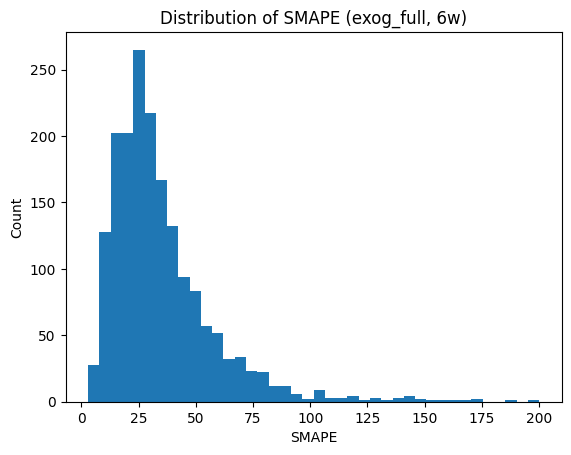

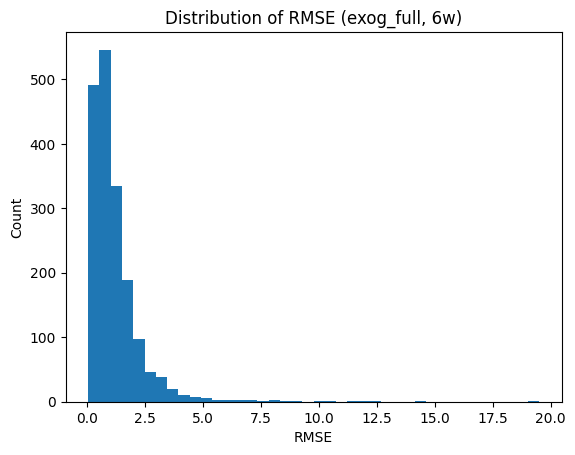

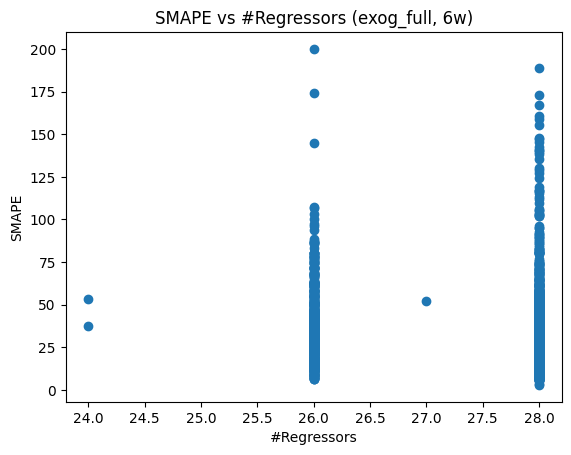

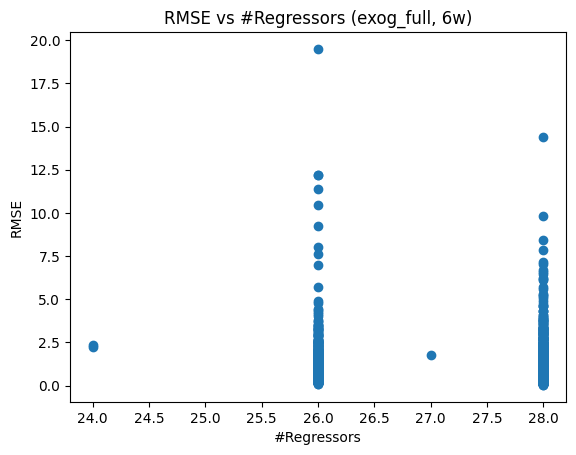

In [5]:
# === EVALUATION: Prophet exog_full (engineered) x 6-week horizon ===
# Reads:  /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exogdiff/all_metrics.{csv,parquet}
# Writes: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exogdiff/{summary_exog_full_h6.csv, leaderboard_exog_full_h6.csv}

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# 2) Paths
BASE = Path("/content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exogdiff")
csv_path = BASE / "all_metrics.csv"
parquet_path = BASE / "all_metrics.parquet"

# 3) Load metrics (CSV preferred)
if csv_path.exists():
    df = pd.read_csv(csv_path)
    used_path = csv_path
elif parquet_path.exists():
    df = pd.read_parquet(parquet_path)
    used_path = parquet_path
else:
    raise FileNotFoundError(f"Could not find metrics at {csv_path} or {parquet_path}. Check training outputs.")

print(f"✅ Loaded metrics from: {used_path}")

# 4) Filter to our run (exog_full, horizon 6)
eval_df = df[(df["cfg"] == "exog_full") & (df["horizon_weeks"] == 6)].copy()
assert not eval_df.empty, "No rows for cfg='exog_full' & horizon=6. Re-check training cell."

# 5) Summary stats
summary = {
    "metrics_file": str(used_path),
    "keywords": int(eval_df["keyword"].nunique()),
    "horizon_weeks": 6,
    "cfg": "exog_full",
    "SMAPE_mean": float(eval_df["smape"].mean()),
    "SMAPE_median": float(eval_df["smape"].median()),
    "SMAPE_p25": float(eval_df["smape"].quantile(0.25)),
    "SMAPE_p75": float(eval_df["smape"].quantile(0.75)),
    "RMSE_mean": float(eval_df["rmse"].mean()),
    "RMSE_median": float(eval_df["rmse"].median()),
    "RMSE_p25": float(eval_df["rmse"].quantile(0.25)),
    "RMSE_p75": float(eval_df["rmse"].quantile(0.75)),
    "avg_n_regressors": float(eval_df["n_regressors"].mean()),
}
summary_df = pd.DataFrame([summary])
print("\n=== Summary (exog_full, 6w) ===")
display(summary_df)

# 6) Per-keyword leaderboard (best = low SMAPE, then low RMSE)
leaderboard = (
    eval_df[["keyword", "smape", "rmse", "n_regressors"]]
    .sort_values(["smape", "rmse"], ascending=[True, True])
    .reset_index(drop=True)
)
print("\n=== Top 20 keywords by SMAPE then RMSE ===")
display(leaderboard.head(20))

# 7) Save artifacts
summary_path = BASE / "summary_exog_full_h6.csv"
leaderboard_path = BASE / "leaderboard_exog_full_h6.csv"
summary_df.to_csv(summary_path, index=False)
leaderboard.to_csv(leaderboard_path, index=False)
print(f"\n💾 Saved summary   → {summary_path}")
print(f"💾 Saved leaderboard → {leaderboard_path}")

# 8) Quick visuals (matplotlib only; one plot each; no custom colors)
plt.figure()
plt.hist(eval_df["smape"].dropna(), bins=40)
plt.title("Distribution of SMAPE (exog_full, 6w)")
plt.xlabel("SMAPE"); plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(eval_df["rmse"].dropna(), bins=40)
plt.title("Distribution of RMSE (exog_full, 6w)")
plt.xlabel("RMSE"); plt.ylabel("Count")
plt.show()

plt.figure()
plt.scatter(eval_df["n_regressors"], eval_df["smape"])
plt.title("SMAPE vs #Regressors (exog_full, 6w)")
plt.xlabel("#Regressors"); plt.ylabel("SMAPE")
plt.show()

plt.figure()
plt.scatter(eval_df["n_regressors"], eval_df["rmse"])
plt.title("RMSE vs #Regressors (exog_full, 6w)")
plt.xlabel("#Regressors"); plt.ylabel("RMSE")
plt.show()


Baseline (h=6)  SMAPE=3.285  RMSE=0.088

Top 20 by ΔSMAPE (bigger = more important):


,regressor,delta_smape,delta_rmse
10,neighbor_mean,3.473565,0.102253
4,impressions_sum,1.262898,0.032642
15,neigh_pca1_lag1,0.986897,0.025377
21,n_dev_tablet_lag1,0.655132,0.007032
17,neigh_pca3_lag1,0.591012,0.018746
6,avg_sim_top25_this_week,0.369407,0.005119
9,n_sim_last_week,0.245620,0.002257
12,neigh_pca1,0.223478,0.004788
0,n_dev_mobile,0.167906,-0.000591
26,n_sim_this_week_lag1,0.115723,0.004619


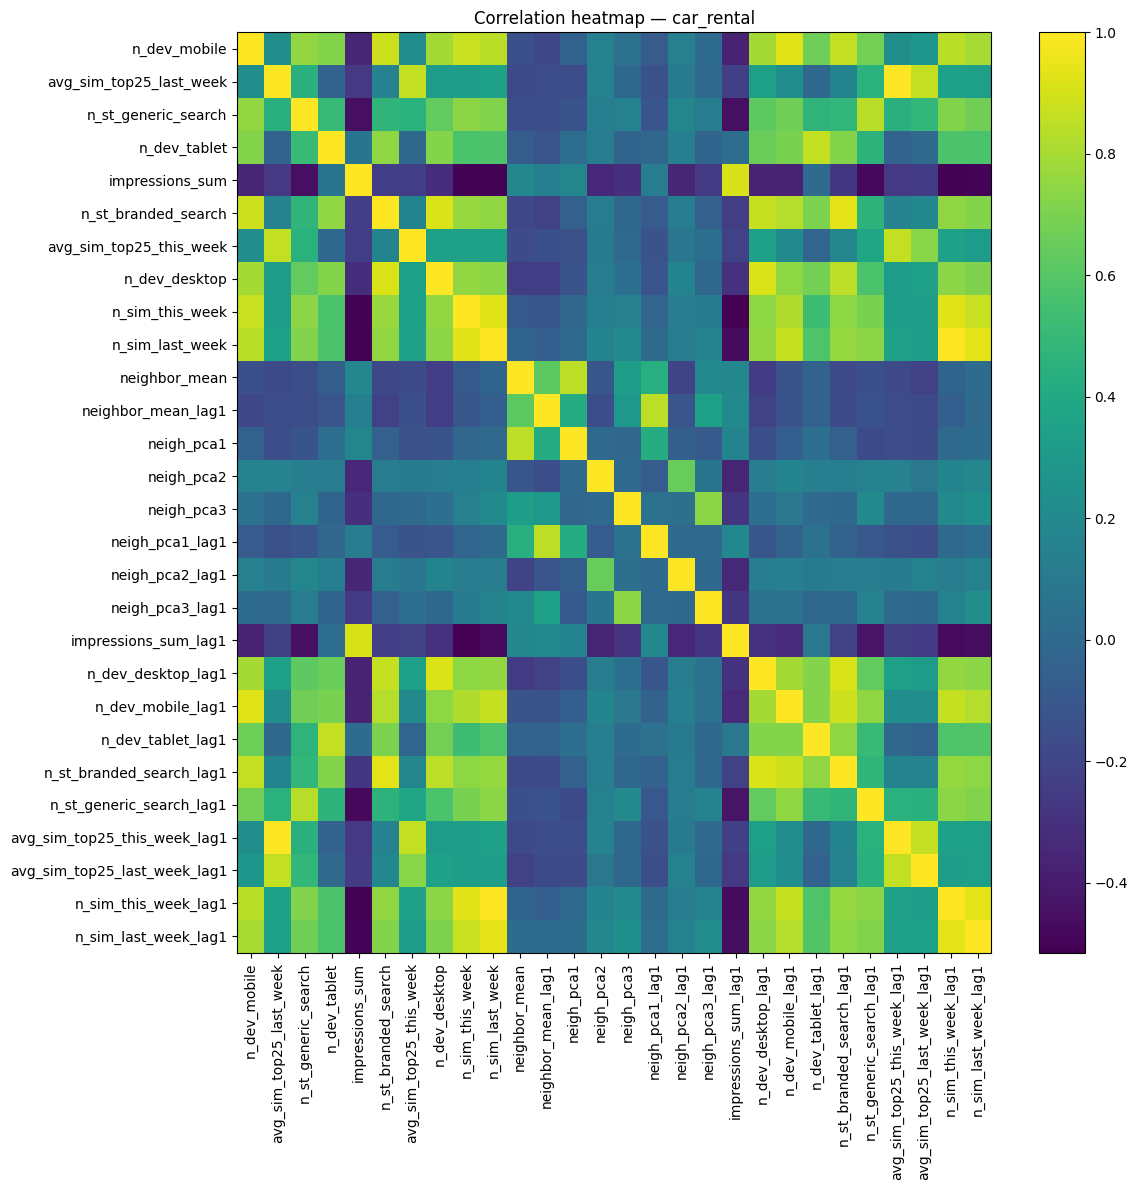


Highest VIFs (potential collinearity):


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,regressor,VIF
0,n_dev_mobile,inf
1,avg_sim_top25_last_week,inf
2,n_st_generic_search,inf
3,n_dev_tablet,inf
5,n_st_branded_search,inf
7,n_dev_desktop,inf
9,n_sim_last_week,inf
23,n_st_generic_search_lag1,inf
24,avg_sim_top25_this_week_lag1,inf
26,n_sim_this_week_lag1,inf


In [13]:
# === PERMUTATION IMPORTANCE + COLLINEARITY for ONE KEYWORD (exog_full engineered, h=6) ===
# No seaborn. Matplotlib only.

from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from datetime import date
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---------- CONFIG ----------
KW = "car_rental"  # <-- change to any keyword filename stem present in your data
IN_DIR = Path("/content/drive/MyDrive/colab_data/cleaned_cpu/keywords_dfs_full_5")
H = 6  # horizon

# ---------- HELPERS (mirror training) ----------
FIXED_SMALL = [
    "impressions_sum",
    "n_dev_desktop", "n_dev_mobile", "n_dev_tablet",
    "n_st_branded_search", "n_st_generic_search",
]
FULL_EXTRAS = [
    "avg_sim_top25_this_week", "avg_sim_top25_last_week",
    "n_sim_this_week", "n_sim_last_week",
]
NEIGH_PREFIX = "cpc_lastweek_"
MIN_VAR_FOR_PCA = 1e-12
MAX_PCA_COMPS = 3

def iso_week_to_date(wwyyyy: str):
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)

def detect_neighbor_cols(cols, prefix=NEIGH_PREFIX):
    import re
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

def prep_base(pl_df: pl.DataFrame):
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
             .filter(pl.col("y").is_not_null())
    )
    return base.to_pandas()[["ds","y"]]

def prep_exog_full(pl_df: pl.DataFrame):
    cols  = pl_df.columns
    neigh = detect_neighbor_cols(cols, NEIGH_PREFIX)
    small_present  = [c for c in FIXED_SMALL if c in cols]
    extras_present = [c for c in FULL_EXTRAS if c in cols]
    reg_cols = neigh + small_present + extras_present
    exdf = (
        pl_df.select(["week"] + reg_cols)
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
    )
    return exdf.to_pandas(), neigh, small_present, extras_present

def add_engineered_features(full_df, neigh_cols):
    df = full_df.copy()
    df = df.replace([np.inf,-np.inf], np.nan).ffill().bfill()
    # neighbor mean and lag
    if neigh_cols:
        df["neighbor_mean"] = df[neigh_cols].mean(axis=1, skipna=True)
        df["neighbor_mean_lag1"] = df["neighbor_mean"].shift(1)
    return df

def add_lags_aligned(train_df, test_df, cols, lag=1):
    t_train, t_test = train_df.copy(), test_df.copy()
    for c in cols:
        if c not in t_train.columns:
            continue
        t_train[f"{c}_lag{lag}"] = t_train[c].shift(lag)
        comb = pd.concat([t_train[[c]], t_test[[c]]], axis=0)
        t_test[f"{c}_lag{lag}"] = comb.shift(lag).iloc[len(t_train):, 0].values
    return t_train, t_test

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    m = denom != 0
    return 100.0 * np.mean(np.abs(y_pred[m]-y_true[m]) / denom[m])

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

# ---------- LOAD ONE KEYWORD ----------
p = IN_DIR / f"{KW}.parquet"
assert p.exists(), f"Keyword file not found: {p}"
df_pl = pl.read_parquet(p)

# base + exogs
pdf_base = prep_base(df_pl)
pdf_exog, neigh_cols, small_present, extras_present = prep_exog_full(df_pl)

full = pdf_base.merge(pdf_exog, on="ds", how="left")
for c in full.columns:
    if c not in ["ds","y"]:
        full[c] = pd.to_numeric(full[c], errors="coerce")
full = full.replace([np.inf,-np.inf], np.nan).ffill().bfill()
full = add_engineered_features(full, neigh_cols)

# split
assert len(full) > H+5, "Series too short for H=6 split"
train = full.iloc[:-H].copy()
test  = full.iloc[-H:].copy()

# PCA on neighbors (train only)
pca_cols = []
if neigh_cols:
    var = train[neigh_cols].var(numeric_only=True).fillna(0.0)
    valid_neigh = [c for c in neigh_cols if var.get(c, 0.0) > MIN_VAR_FOR_PCA]
    if valid_neigh:
        scaler_neigh = StandardScaler()
        Xtr = scaler_neigh.fit_transform(train[valid_neigh].values)
        n_comps = int(np.clip(min(Xtr.shape[1], MAX_PCA_COMPS), 1, MAX_PCA_COMPS))
        pca = PCA(n_components=n_comps, svd_solver="randomized", random_state=42)
        Ztr = pca.fit_transform(Xtr)
        Zte = pca.transform(scaler_neigh.transform(test[valid_neigh].values))
        for j in range(n_comps):
            comp = f"neigh_pca{j+1}"
            train[comp] = Ztr[:, j]
            test[comp]  = Zte[:, j]
            pca_cols.append(comp)
        # lag1 for PCA
        for comp in pca_cols:
            train[f"{comp}_lag1"] = train[comp].shift(1)
            comb = pd.concat([train[[comp]], test[[comp]]], axis=0)
            test[f"{comp}_lag1"] = comb.shift(1).iloc[len(train):, 0].values

# generic lags for selected exogs
lag_targets = []
lag_targets += [c for c in ["impressions_sum","n_dev_desktop","n_dev_mobile","n_dev_tablet",
                            "n_st_branded_search","n_st_generic_search"] if c in train.columns]
lag_targets += [c for c in extras_present if c in train.columns]
if "neighbor_mean" in train.columns:
    lag_targets += ["neighbor_mean"]

train, test = add_lags_aligned(train, test, lag_targets, lag=1)
train = train.iloc[1:].copy()  # drop first lag-NaN row

# build regressor set (same spirit as training)
reg_cols = []
base_exogs = list(set(FIXED_SMALL + FULL_EXTRAS) & set(train.columns))
reg_cols += base_exogs
for c in ["neighbor_mean","neighbor_mean_lag1"]:
    if c in train.columns: reg_cols.append(c)
for c in pca_cols + [f"{c}_lag1" for c in pca_cols]:
    if c in train.columns: reg_cols.append(c)
for c in [f"{c}_lag1" for c in lag_targets]:
    if c in train.columns and c not in reg_cols: reg_cols.append(c)

# prune zero-variance/all-NaN
nun = train[reg_cols].nunique(dropna=False)
reg_cols = [c for c in reg_cols if nun.get(c, 0) > 1 and not train[c].isnull().all()]

# fill residual NaNs
if reg_cols:
    train[reg_cols] = train[reg_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()
    test[reg_cols]  = test[reg_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()

# scale
scaler_all = StandardScaler()
train_scaled = train[["ds","y"] + reg_cols].copy()
test_scaled  = test[["ds","y"] + reg_cols].copy()
train_scaled[reg_cols] = scaler_all.fit_transform(train_scaled[reg_cols].values)
test_scaled[reg_cols]  = scaler_all.transform(test_scaled[reg_cols].values)

# fit Prophet
m = Prophet(
    daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True,
    seasonality_mode="additive", changepoint_prior_scale=0.05, interval_width=0.8,
    stan_backend="CMDSTANPY",
)
for r in reg_cols:
    # a touch of shrinkage
    m.add_regressor(r, standardize=True, prior_scale=0.2)
m.fit(train_scaled[["ds","y"] + reg_cols])

# baseline forecast
fc_base = m.predict(test_scaled[["ds"] + reg_cols])
y_true = test_scaled["y"].values
y_hat  = fc_base["yhat"].values
base_smape = smape(y_true, y_hat)
base_rmse  = rmse(y_true, y_hat)
print(f"Baseline (h={H})  SMAPE={base_smape:.3f}  RMSE={base_rmse:.3f}")

# ---------- PERMUTATION IMPORTANCE (test window only) ----------
imp_rows = []
rng = np.random.default_rng(42)
for col in reg_cols:
    Xp = test_scaled[["ds"] + reg_cols].copy()
    # shuffle *within the test window* for this regressor
    shuffled = Xp[col].values.copy()
    rng.shuffle(shuffled)
    Xp[col] = shuffled

    fc = m.predict(Xp)
    y_hat_p = fc["yhat"].values
    sm = smape(y_true, y_hat_p)
    rm = rmse(y_true, y_hat_p)
    imp_rows.append({
        "regressor": col,
        "delta_smape": sm - base_smape,
        "delta_rmse": rm - base_rmse,
    })

imp_df = pd.DataFrame(imp_rows).sort_values(["delta_smape","delta_rmse"], ascending=False)
print("\nTop 20 by ΔSMAPE (bigger = more important):")
display(imp_df.head(20))

# ---------- COLLINEARITY ----------
X = train_scaled[reg_cols].copy()
corr = X.corr()

plt.figure(figsize=(min(12, 0.3*len(reg_cols)+4), min(12, 0.3*len(reg_cols)+4)))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(reg_cols)), reg_cols, rotation=90)
plt.yticks(range(len(reg_cols)), reg_cols)
plt.title(f"Correlation heatmap — {KW}")
plt.tight_layout()
plt.show()

# VIF
Xv = X.replace([np.inf,-np.inf], np.nan).dropna(axis=0)
X_ = np.column_stack([np.ones(len(Xv)), Xv.values])
cols_ = ['const'] + list(Xv.columns)
vif_vals = []
for i in range(1, X_.shape[1]):  # skip intercept
    try:
        vif_vals.append((cols_[i], variance_inflation_factor(X_, i)))
    except Exception:
        vif_vals.append((cols_[i], np.nan))
vif_df = pd.DataFrame(vif_vals, columns=['regressor','VIF']).sort_values('VIF', ascending=False)
print("\nHighest VIFs (potential collinearity):")
display(vif_df.head(20))


In [14]:
# === TRAIN: Prophet (exog_lean) x 6-week horizon ===
# INPUT : /content/drive/MyDrive/colab_data/cleaned_cpu/keywords_dfs_full_5
# OUTPUT: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoglean
# Writes: per-keyword forecasts + consolidated all_metrics.{csv,parquet}

!pip -q install polars pyarrow tqdm prophet cmdstanpy numpy pandas scikit-learn

from pathlib import Path
from datetime import date
import re
import numpy as np, pandas as pd, polars as pl
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

# ---------------- Paths ----------------
BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
IN_DIR = BASE / "keywords_dfs_full_5"
OUT    = BASE / "prophet_semantic_exoglean"
OUT.mkdir(parents=True, exist_ok=True)

ALL_METRICS_CSV     = OUT / "all_metrics.csv"
ALL_METRICS_PARQUET = OUT / "all_metrics.parquet"

CFG_NAME = "exog_lean"
H = 6
FC_DIR = OUT / CFG_NAME / f"h{H}" / "forecasts"
FC_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- Config ----------------
NEIGHBOR_PREFIX = "cpc_lastweek_"

# Lean regressors to keep (plus neighbor_mean_lag1 which we compute)
LEAN_KEEP = [
    "impressions_sum",
    "n_dev_mobile",
    "n_st_branded_search",
    "avg_sim_top25_this_week",
]

EXCLUDE_ALWAYS = {"week","week_prev","year","week_num","keyword","cpc_week","y","y_log","ds"}
NUM_DTYPES     = (pl.Float32, pl.Float64, pl.Int32, pl.Int64, pl.UInt32, pl.UInt64)

# ---------------- Helpers ----------------
def iso_week_to_date(wwyyyy: str) -> date:
    # wwyyyy like "42-2022" -> Monday of that ISO week
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, dtype=float), np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = denom != 0
    return float(100.0 * np.mean(np.abs(y_pred[mask] - y_true[mask]) / denom[mask]))

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

def make_prophet(add_regressors=None):
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.05,
        interval_width=0.8,
        stan_backend="CMDSTANPY",
    )
    if add_regressors:
        for r in add_regressors:
            # stronger shrinkage because lean spec still could pick up noise
            m.add_regressor(r, standardize=True, prior_scale=0.1)
    return m

def detect_neighbor_cols(cols, prefix=NEIGHBOR_PREFIX):
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

def prep_frames(pl_df: pl.DataFrame):
    """Return pandas df with ds,y and lean regressors (+ neighbor_mean_lag1)."""
    # base ds,y
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
             .filter(pl.col("y").is_not_null())
    ).to_pandas()[["ds","y"]]

    # neighbors
    neigh_cols = detect_neighbor_cols(pl_df.columns, NEIGHBOR_PREFIX)
    if not neigh_cols:
        # per your note, should not happen; but handle gracefully
        exdf = pl.DataFrame({"ds": [], "dummy": []}).to_pandas().drop(columns=["dummy"])
        reg_cols = []
    else:
        # exog kept
        keep_present = [c for c in LEAN_KEEP if c in pl_df.columns]

        ex_cols = ["week"] + keep_present + neigh_cols
        exdf = (
            pl_df.select(ex_cols)
                 .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
                 .drop("week").sort("ds")
        ).to_pandas()

        # numeric coercion
        for c in keep_present + neigh_cols:
            exdf[c] = pd.to_numeric(exdf[c], errors="coerce")

        # neighbor mean and lag1
        exdf["neighbor_mean"] = exdf[neigh_cols].mean(axis=1, skipna=True)
        exdf["neighbor_mean_lag1"] = exdf["neighbor_mean"].shift(1)

        reg_cols = keep_present + ["neighbor_mean_lag1"]

    # join, fill
    full = base.merge(exdf[["ds"] + reg_cols] if reg_cols else base[["ds"]], on="ds", how="left")
    if reg_cols:
        full[reg_cols] = full[reg_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()

    return full[["ds","y"] + reg_cols] if reg_cols else full[["ds","y"]], reg_cols

def train_eval_save(pdf, reg_cols, kw, h):
    if len(pdf) <= h + 5:
        return np.nan, np.nan, 0

    # Split train/test
    train = pdf.iloc[:-h].copy()
    test  = pdf.iloc[-h:].copy()

    # Drop first train row if any *_lag1 present (avoid initial NaN)
    if any(c.endswith("_lag1") for c in reg_cols):
        train = train.iloc[1:].copy()

    # Scale regressors (fit on train only), Prophet also standardizes internally but we keep this for stability
    if reg_cols:
        scaler = StandardScaler()
        train[reg_cols] = scaler.fit_transform(train[reg_cols].values)
        test[reg_cols]  = scaler.transform(test[reg_cols].values)

    # Fit Prophet
    m = make_prophet(add_regressors=reg_cols if reg_cols else None)
    m.fit(train[["ds","y"] + (reg_cols if reg_cols else [])])

    # Forecast & save
    X = test[["ds"] + (reg_cols if reg_cols else [])]
    fc = m.predict(X)

    out_fc = FC_DIR / f"{kw}.csv"
    pd.DataFrame({
        "ds": test["ds"],
        "y_true": test["y"],
        "yhat": fc["yhat"],
        "yhat_lower": fc.get("yhat_lower", np.nan),
        "yhat_upper": fc.get("yhat_upper", np.nan),
    }).to_csv(out_fc, index=False)

    return smape(test["y"], fc["yhat"]), rmse(test["y"], fc["yhat"]), len(reg_cols)

# ---------------- Train all keywords; write ONE metrics file ----------------
files = sorted(IN_DIR.glob("*.parquet"))
assert files, f"No parquet files found in {IN_DIR}"

records = []

for p in tqdm(files, desc="Prophet exog_lean x 6w"):
    kw = p.stem
    df_pl = pl.read_parquet(p)

    if "week" not in df_pl.columns or "cpc_week" not in df_pl.columns:
        continue

    pdf, regs = prep_frames(df_pl)
    s, r, k = train_eval_save(pdf, regs, kw, H)
    records.append({
        "keyword": kw,
        "horizon_weeks": H,
        "cfg": CFG_NAME,
        "smape": s,
        "rmse": r,
        "n_regressors": k,
    })

# Save consolidated metrics
all_metrics = pd.DataFrame(records).sort_values(["keyword","horizon_weeks","cfg"])
all_metrics.to_csv(ALL_METRICS_CSV, index=False)
all_metrics.to_parquet(ALL_METRICS_PARQUET, index=False)

print("\n✅ Training complete.")
print(f"- all metrics (csv):     {ALL_METRICS_CSV}")
print(f"- all metrics (parquet): {ALL_METRICS_PARQUET}")

dfm = all_metrics[all_metrics["cfg"]==CFG_NAME]
avg_regs = float(dfm["n_regressors"].mean()) if not dfm.empty else 0.0
print(f"{CFG_NAME}: avg_n_regressors = {avg_regs:.2f}")


Prophet exog_lean x 6w:   0%|          | 0/1811 [00:00<?, ?it/s]


✅ Training complete.
- all metrics (csv):     /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoglean/all_metrics.csv
- all metrics (parquet): /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoglean/all_metrics.parquet
exog_lean: avg_n_regressors = 5.00



=== Prophet 6-week Horizon Summary ===


,cfg,keywords,SMAPE_mean,SMAPE_median,RMSE_mean,RMSE_median,avg_n_regressors
0,exog_full,1811,35.12728,29.463123,1.188567,0.852898,27.318056
1,exog_lean,1811,34.47096,29.926182,1.178892,0.863586,5.000000


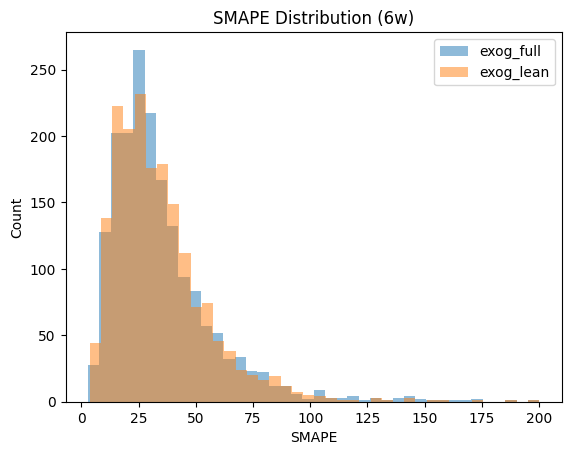

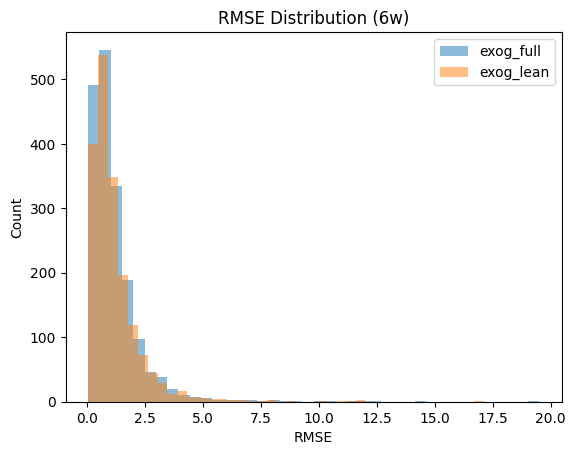


=== Aggregate Δ (lean - full) ===
ΔSMAPE mean: -0.656, median: 0.374
ΔRMSE  mean: -0.010, median: 0.012


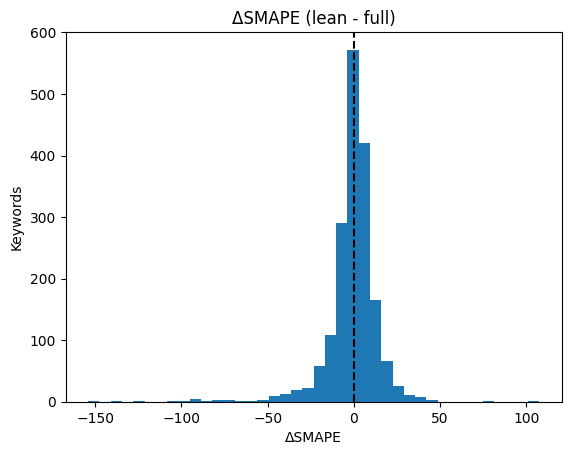

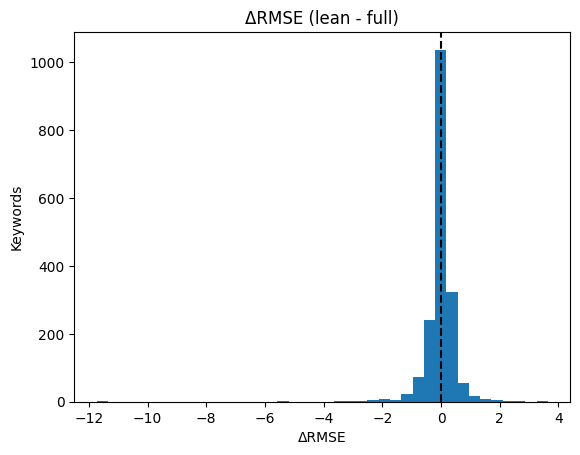

In [15]:
# === EVALUATION: Prophet exog_lean (6w) ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

BASE = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
LEAN = BASE / "prophet_semantic_exoglean" / "all_metrics.csv"
FULL = BASE / "prophet_semantic_exogdiff" / "all_metrics.csv"  # your earlier exog_full path

# Load
lean_df = pd.read_csv(LEAN)
full_df = pd.read_csv(FULL)

# Filter to 6w horizon
lean = lean_df[lean_df["horizon_weeks"]==6].copy()
full = full_df[(full_df["cfg"]=="exog_full") & (full_df["horizon_weeks"]==6)].copy()

# Summary
def summarize(df, name):
    return {
        "cfg": name,
        "keywords": df["keyword"].nunique(),
        "SMAPE_mean": df["smape"].mean(),
        "SMAPE_median": df["smape"].median(),
        "RMSE_mean": df["rmse"].mean(),
        "RMSE_median": df["rmse"].median(),
        "avg_n_regressors": df["n_regressors"].mean(),
    }

summary = pd.DataFrame([summarize(full,"exog_full"), summarize(lean,"exog_lean")])
print("\n=== Prophet 6-week Horizon Summary ===")
display(summary)

# Distribution comparison
plt.figure()
plt.hist(full["smape"], bins=40, alpha=0.5, label="exog_full")
plt.hist(lean["smape"], bins=40, alpha=0.5, label="exog_lean")
plt.legend(); plt.xlabel("SMAPE"); plt.ylabel("Count"); plt.title("SMAPE Distribution (6w)")
plt.show()

plt.figure()
plt.hist(full["rmse"], bins=40, alpha=0.5, label="exog_full")
plt.hist(lean["rmse"], bins=40, alpha=0.5, label="exog_lean")
plt.legend(); plt.xlabel("RMSE"); plt.ylabel("Count"); plt.title("RMSE Distribution (6w)")
plt.show()

# Per-keyword deltas
merged = lean.merge(full[["keyword","smape","rmse"]], on="keyword", how="inner", suffixes=("_lean","_full"))
merged["delta_smape"] = merged["smape_lean"] - merged["smape_full"]
merged["delta_rmse"] = merged["rmse_lean"] - merged["rmse_full"]
print("\n=== Aggregate Δ (lean - full) ===")
print(f"ΔSMAPE mean: {merged['delta_smape'].mean():.3f}, median: {merged['delta_smape'].median():.3f}")
print(f"ΔRMSE  mean: {merged['delta_rmse'].mean():.3f}, median: {merged['delta_rmse'].median():.3f}")

plt.figure()
plt.hist(merged["delta_smape"], bins=40)
plt.title("ΔSMAPE (lean - full)"); plt.xlabel("ΔSMAPE"); plt.ylabel("Keywords")
plt.axvline(0, color="black", linestyle="--")
plt.show()

plt.figure()
plt.hist(merged["delta_rmse"], bins=40)
plt.title("ΔRMSE (lean - full)"); plt.xlabel("ΔRMSE"); plt.ylabel("Keywords")
plt.axvline(0, color="black", linestyle="--")
plt.show()


In [9]:
# === TRAIN: Prophet (exog_hybrid) x 6-week horizon ===
# INPUT : /content/drive/MyDrive/colab_data/cleaned_cpu/keywords_dfs_full_5
# OUTPUT: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid
!pip -q install polars pyarrow tqdm prophet cmdstanpy numpy pandas scikit-learn

from pathlib import Path
from datetime import date
import re
import numpy as np, pandas as pd, polars as pl
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
IN_DIR = BASE / "keywords_dfs_full_5"
OUT    = BASE / "prophet_semantic_exoghybrid"
OUT.mkdir(parents=True, exist_ok=True)

ALL_METRICS_CSV     = OUT / "all_metrics.csv"
ALL_METRICS_PARQUET = OUT / "all_metrics.parquet"

H = 6
CFG_NAME = "exog_hybrid"
FC_DIR = OUT / CFG_NAME / f"h{H}" / "forecasts"
FC_DIR.mkdir(parents=True, exist_ok=True)

NEIGH_PREFIX = "cpc_lastweek_"

KEEP_MAIN = [
    "impressions_sum", "impressions_sum_lag1",
    "n_dev_mobile",
    "n_st_branded_search",
    "avg_sim_top25_this_week", "n_sim_last_week",
    "avg_sim_top25_last_week_lag1",
]

def iso_week_to_date(wwyyyy: str):
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    m = denom != 0
    return 100*np.mean(np.abs(y_pred[m]-y_true[m]) / denom[m])

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))

def make_prophet(add_regressors=None):
    m = Prophet(
        daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.1,     # slightly more flexible
        interval_width=0.8,
        stan_backend="CMDSTANPY",
    )
    if add_regressors:
        for r in add_regressors:
            m.add_regressor(r, standardize=True, prior_scale=0.2)
    return m

def detect_neighbor_cols(cols, prefix=NEIGH_PREFIX):
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

def prep_frames(pl_df):
    # base ds,y
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds").filter(pl.col("y").is_not_null())
    ).to_pandas()[["ds","y"]]

    # detect neighbors
    neigh_cols = detect_neighbor_cols(pl_df.columns, NEIGH_PREFIX)
    ex_cols = ["week"] + KEEP_MAIN + neigh_cols
    ex_cols = [c for c in ex_cols if c in pl_df.columns or c.startswith(NEIGH_PREFIX)]

    exdf = (
        pl_df.select([c for c in ex_cols if c in pl_df.columns])
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
    ).to_pandas()

    for c in exdf.columns:
        if c not in ["ds"]:
            exdf[c] = pd.to_numeric(exdf[c], errors="coerce")

    # compute neighbor_mean + lag1
    exdf["neighbor_mean"] = exdf[neigh_cols].mean(axis=1, skipna=True)
    exdf["neighbor_mean_lag1"] = exdf["neighbor_mean"].shift(1)

    # PCA on neighbors (train-time)
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    neigh_df = exdf[neigh_cols].replace([np.inf,-np.inf],np.nan).ffill().bfill()
    scaler = StandardScaler()
    X = scaler.fit_transform(neigh_df)
    pca = PCA(n_components=min(2,X.shape[1]))
    Z = pca.fit_transform(X)
    exdf["neigh_pca1"] = Z[:,0]
    if Z.shape[1]>1:
        exdf["neigh_pca2"] = Z[:,1]
    exdf["neigh_pca1_lag1"] = exdf["neigh_pca1"].shift(1)
    if "neigh_pca2" in exdf:
        exdf["neigh_pca2_lag1"] = exdf["neigh_pca2"].shift(1)

    reg_cols = [c for c in exdf.columns if c not in ["ds"] + neigh_cols]

    full = base.merge(exdf[["ds"] + reg_cols], on="ds", how="left").replace([np.inf,-np.inf],np.nan).ffill().bfill()
    return full[["ds","y"] + reg_cols], reg_cols

def train_eval_save(pdf, reg_cols, kw, h):
    if len(pdf)<=h+5: return np.nan,np.nan,0
    train, test = pdf.iloc[:-h].copy(), pdf.iloc[-h:].copy()
    if any(c.endswith("_lag1") for c in reg_cols):
        train=train.iloc[1:].copy()
    if reg_cols:
        sc=StandardScaler()
        train[reg_cols]=sc.fit_transform(train[reg_cols])
        test[reg_cols]=sc.transform(test[reg_cols])
    m=make_prophet(reg_cols)
    m.fit(train[["ds","y"]+reg_cols])
    fc=m.predict(test[["ds"]+reg_cols])
    pd.DataFrame({
        "ds":test["ds"],"y_true":test["y"],"yhat":fc["yhat"],
        "yhat_lower":fc.get("yhat_lower",np.nan),"yhat_upper":fc.get("yhat_upper",np.nan),
    }).to_csv(FC_DIR/f"{kw}.csv",index=False)
    return smape(test["y"],fc["yhat"]),rmse(test["y"],fc["yhat"]),len(reg_cols)

# --- main loop ---
records=[]
for p in tqdm(sorted(IN_DIR.glob("*.parquet")),desc="Prophet exog_hybrid x 6w"):
    kw=p.stem
    df_pl=pl.read_parquet(p)
    if "week" not in df_pl.columns or "cpc_week" not in df_pl.columns: continue
    pdf,regs=prep_frames(df_pl)
    s,r,k=train_eval_save(pdf,regs,kw,H)
    records.append({"keyword":kw,"horizon_weeks":H,"cfg":CFG_NAME,"smape":s,"rmse":r,"n_regressors":k})

all_metrics=pd.DataFrame(records).sort_values(["keyword","cfg"])
all_metrics.to_csv(ALL_METRICS_CSV,index=False)
all_metrics.to_parquet(ALL_METRICS_PARQUET,index=False)

print("\n✅ Training complete.")
print(f"- all metrics (csv): {ALL_METRICS_CSV}")
dfm=all_metrics
print(f"{CFG_NAME}: avg_n_regressors = {dfm['n_regressors'].mean():.2f}")


Prophet exog_hybrid x 6w:   0%|          | 0/1811 [00:00<?, ?it/s]


✅ Training complete.
- all metrics (csv): /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid/all_metrics.csv
exog_hybrid: avg_n_regressors = 11.00


=== exog_hybrid — 6-week horizon summary ===


,keywords,SMAPE_mean,SMAPE_median,SMAPE_std,SMAPE_p10,SMAPE_p25,SMAPE_p50,SMAPE_p75,SMAPE_p90,RMSE_mean,RMSE_median,RMSE_std,RMSE_p10,RMSE_p25,RMSE_p50,RMSE_p75,RMSE_p90,avg_n_regressors
0,1811,32.84215,28.496272,20.611887,12.573863,18.676648,28.496272,41.373172,58.255068,1.116635,0.82166,1.169701,0.277438,0.471247,0.82166,1.368581,2.228881,11.0



=== Top 20 keywords (lowest SMAPE, then RMSE) ===


,keyword,smape,rmse,n_regressors
0,car_rental_airport_edinburgh,3.551142,0.315955,11
1,sixt_rent,3.581486,0.025821,11
2,car_rental_edinburgh,4.412384,0.301873,11
3,car_rental_weekly,4.428204,0.147004,11
4,car_rental_airport_phoenix,4.783053,0.270757,11
5,car_rental_24_hour,4.828411,0.086558,11
6,car_rental_sixt,4.948456,0.047219,11
7,dollar_rent,5.243133,0.082290,11
8,car_rental_tbilisi,5.324794,0.140542,11
9,car_rental_dollar_com,5.351255,0.083258,11


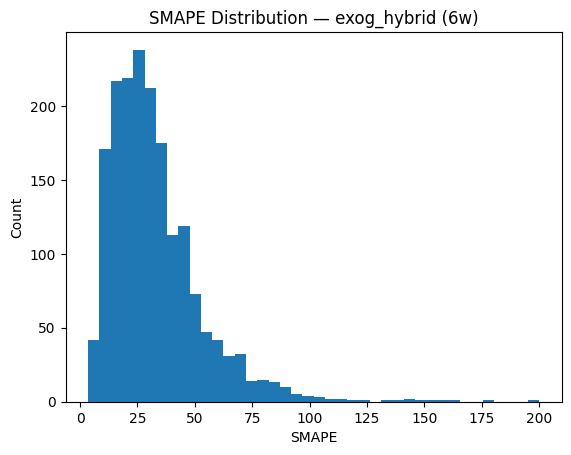

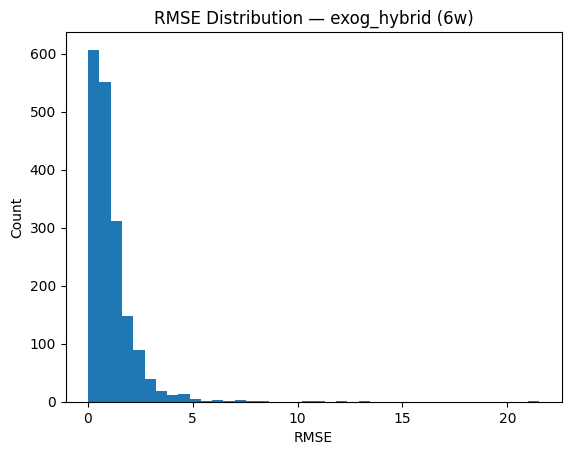


=== exog_hybrid vs exog_full (6w) ===


,exog_full_SMAPE_mean,exog_full_SMAPE_median,exog_full_RMSE_mean,exog_full_RMSE_median,exog_hybrid_SMAPE_mean,exog_hybrid_SMAPE_median,exog_hybrid_RMSE_mean,exog_hybrid_RMSE_median
0,35.12728,29.463123,1.188567,0.852898,32.84215,28.496272,1.116635,0.82166



Δ (hybrid - full): mean/median
ΔSMAPE mean: -2.285 | median: -0.879
ΔRMSE  mean: -0.072 | median: -0.024


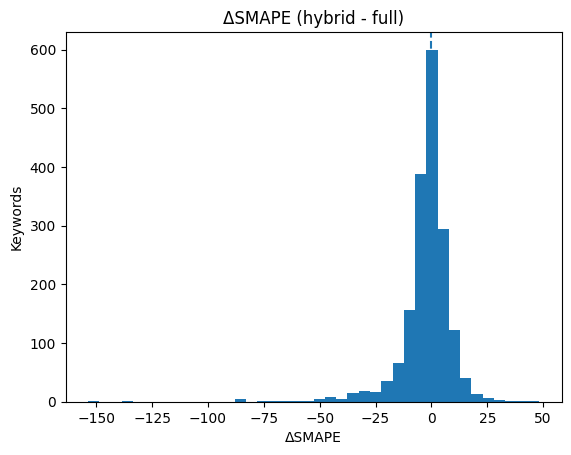

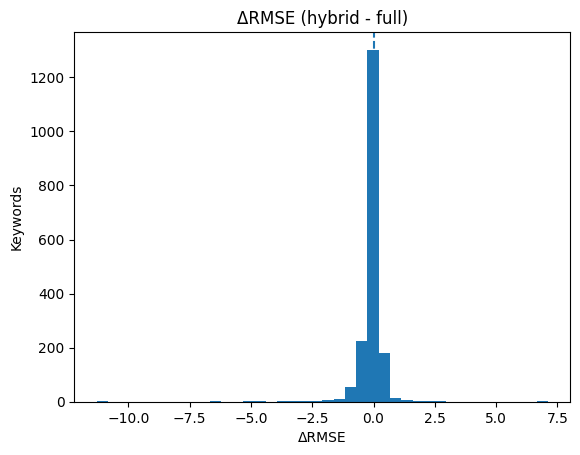

In [2]:
# === EVALUATION: Prophet exog_hybrid (6w) ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

BASE = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")

HYB_PATH  = BASE / "prophet_semantic_exoghybrid" / "all_metrics.csv"
FULL_PATH = BASE / "prophet_semantic_exogdiff"   / "all_metrics.csv"  # optional comparison

assert HYB_PATH.exists(), f"Missing: {HYB_PATH}"
hyb = pd.read_csv(HYB_PATH)
hyb = hyb[(hyb["cfg"]=="exog_hybrid") & (hyb["horizon_weeks"]==6)].copy()

# --- Summary with quantiles + standard deviation ---
print("=== exog_hybrid — 6-week horizon summary ===")
summary = {
    "keywords": int(hyb["keyword"].nunique()),

    # SMAPE stats
    "SMAPE_mean": float(hyb["smape"].mean()),
    "SMAPE_median": float(hyb["smape"].median()),
    "SMAPE_std": float(hyb["smape"].std(ddof=1)),
    "SMAPE_p10": float(hyb["smape"].quantile(0.10)),
    "SMAPE_p25": float(hyb["smape"].quantile(0.25)),
    "SMAPE_p50": float(hyb["smape"].quantile(0.50)),
    "SMAPE_p75": float(hyb["smape"].quantile(0.75)),
    "SMAPE_p90": float(hyb["smape"].quantile(0.90)),

    # RMSE stats
    "RMSE_mean": float(hyb["rmse"].mean()),
    "RMSE_median": float(hyb["rmse"].median()),
    "RMSE_std": float(hyb["rmse"].std(ddof=1)),
    "RMSE_p10": float(hyb["rmse"].quantile(0.10)),
    "RMSE_p25": float(hyb["rmse"].quantile(0.25)),
    "RMSE_p50": float(hyb["rmse"].quantile(0.50)),
    "RMSE_p75": float(hyb["rmse"].quantile(0.75)),
    "RMSE_p90": float(hyb["rmse"].quantile(0.90)),

    "avg_n_regressors": float(hyb["n_regressors"].mean()),
}
display(pd.DataFrame([summary]))

# --- Per-keyword leaderboard ---
leaderboard = (
    hyb[["keyword","smape","rmse","n_regressors"]]
    .sort_values(["smape","rmse"], ascending=[True, True])
    .reset_index(drop=True)
)
print("\n=== Top 20 keywords (lowest SMAPE, then RMSE) ===")
display(leaderboard.head(20))

# --- Distributions ---
plt.figure()
plt.hist(hyb["smape"].dropna(), bins=40)
plt.title("SMAPE Distribution — exog_hybrid (6w)")
plt.xlabel("SMAPE"); plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(hyb["rmse"].dropna(), bins=40)
plt.title("RMSE Distribution — exog_hybrid (6w)")
plt.xlabel("RMSE"); plt.ylabel("Count")
plt.show()

# --- Optional comparison with exog_full ---
if FULL_PATH.exists():
    full = pd.read_csv(FULL_PATH)
    full = full[(full["cfg"]=="exog_full") & (full["horizon_weeks"]==6)].copy()

    comp = {
        "exog_full_SMAPE_mean": float(full["smape"].mean()),
        "exog_full_SMAPE_median": float(full["smape"].median()),
        "exog_full_RMSE_mean": float(full["rmse"].mean()),
        "exog_full_RMSE_median": float(full["rmse"].median()),
        "exog_hybrid_SMAPE_mean": summary["SMAPE_mean"],
        "exog_hybrid_SMAPE_median": summary["SMAPE_median"],
        "exog_hybrid_RMSE_mean": summary["RMSE_mean"],
        "exog_hybrid_RMSE_median": summary["RMSE_median"],
    }
    print("\n=== exog_hybrid vs exog_full (6w) ===")
    display(pd.DataFrame([comp]))

    merged = hyb.merge(full[["keyword","smape","rmse"]], on="keyword", suffixes=("_hyb","_full"))
    merged["delta_smape"] = merged["smape_hyb"] - merged["smape_full"]
    merged["delta_rmse"]  = merged["rmse_hyb"]  - merged["rmse_full"]

    print("\nΔ (hybrid - full): mean/median")
    print(f"ΔSMAPE mean: {merged['delta_smape'].mean():.3f} | median: {merged['delta_smape'].median():.3f}")
    print(f"ΔRMSE  mean: {merged['delta_rmse'].mean():.3f} | median: {merged['delta_rmse'].median():.3f}")

    plt.figure()
    plt.hist(merged["delta_smape"], bins=40)
    plt.title("ΔSMAPE (hybrid - full)")
    plt.xlabel("ΔSMAPE"); plt.ylabel("Keywords")
    plt.axvline(0, linestyle="--")
    plt.show()

    plt.figure()
    plt.hist(merged["delta_rmse"], bins=40)
    plt.title("ΔRMSE (hybrid - full)")
    plt.xlabel("ΔRMSE"); plt.ylabel("Keywords")
    plt.axvline(0, linestyle="--")
    plt.show()
else:
    print("\n(exog_full metrics not found; skipping comparison.)")


# same model but eliminate double scaling and pca leakage

In [4]:
# === TRAIN: Prophet (exog_hybrid) x 6-week horizon ===
# INPUT : /content/drive/MyDrive/colab_data/cleaned_cpu/keywords_dfs_full_5
# OUTPUT: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid
!pip -q install polars pyarrow tqdm prophet cmdstanpy numpy pandas scikit-learn

from pathlib import Path
from datetime import date
import re
import numpy as np, pandas as pd, polars as pl
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from prophet import Prophet

BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
IN_DIR = BASE / "keywords_dfs_full_5"
OUT    = BASE / "prophet_semantic_exoghybrid"
OUT.mkdir(parents=True, exist_ok=True)

ALL_METRICS_CSV     = OUT / "all_metrics.csv"
ALL_METRICS_PARQUET = OUT / "all_metrics.parquet"

H = 6
CFG_NAME = "exog_hybrid"
FC_DIR = OUT / CFG_NAME / f"h{H}" / "forecasts"
FC_DIR.mkdir(parents=True, exist_ok=True)

NEIGH_PREFIX = "cpc_lastweek_"

KEEP_MAIN = [
    "impressions_sum", "impressions_sum_lag1",
    "n_dev_mobile",
    "n_st_branded_search",
    "avg_sim_top25_this_week", "n_sim_last_week",
    "avg_sim_top25_last_week_lag1",
]

def iso_week_to_date(wwyyyy: str):
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    m = denom != 0
    return 100*np.mean(np.abs(y_pred[m]-y_true[m]) / denom[m])

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))

def make_prophet(add_regressors=None):
    # weekly_seasonality disabled for weekly data; no internal standardization
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.1,
        interval_width=0.8,
        stan_backend="CMDSTANPY",
    )
    if add_regressors:
        for r in add_regressors:
            m.add_regressor(r, standardize=False, prior_scale=0.2)
    return m

def detect_neighbor_cols(cols, prefix=NEIGH_PREFIX):
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

def prep_frames(pl_df):
    # base ds,y
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds").filter(pl.col("y").is_not_null())
    ).to_pandas()[["ds","y"]]

    # detect neighbors
    neigh_cols = detect_neighbor_cols(pl_df.columns, NEIGH_PREFIX)
    ex_cols = ["week"] + KEEP_MAIN + neigh_cols
    ex_cols = [c for c in ex_cols if c in pl_df.columns or c.startswith(NEIGH_PREFIX)]

    exdf = (
        pl_df.select([c for c in ex_cols if c in pl_df.columns])
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
    ).to_pandas()

    for c in exdf.columns:
        if c not in ["ds"]:
            exdf[c] = pd.to_numeric(exdf[c], errors="coerce")

    # neighbor_mean + lag1 (kept as part of hybrid)
    if neigh_cols:
        exdf["neighbor_mean"] = exdf[neigh_cols].mean(axis=1, skipna=True)
        exdf["neighbor_mean_lag1"] = exdf["neighbor_mean"].shift(1)

    # Regressors (excluding raw neighbor cols; they'll be kept separately)
    reg_cols = [c for c in exdf.columns if c not in ["ds"] + neigh_cols]

    # IMPORTANT: keep neigh_cols in the merged frame so downstream PCA can access them
    full = (
        base.merge(exdf[["ds"] + reg_cols + neigh_cols], on="ds", how="left")
            .replace([np.inf, -np.inf], np.nan).ffill().bfill()
    )

    # Return frame with both reg_cols and neigh_cols (for train-time PCA)
    return full[["ds","y"] + reg_cols + neigh_cols], reg_cols, neigh_cols


def train_eval_save(pdf, reg_cols, neigh_cols, kw, h):
    if len(pdf) <= h + 5:
        return np.nan, np.nan, 0

    n = len(pdf)
    split = n - h
    train = pdf.iloc[:split].copy()
    test  = pdf.iloc[split:].copy()

    # === PCA on neighbors: fit on TRAIN, transform TRAIN+TEST ===
    pca_cols = []
    if len(neigh_cols) > 0:
        train_N = train[neigh_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()
        test_N  = test [neigh_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()

        scN = StandardScaler()
        Xtr = scN.fit_transform(train_N)
        Xte = scN.transform(test_N)

        k = min(2, Xtr.shape[1])
        from sklearn.decomposition import PCA
        pca = PCA(n_components=k)
        Ztr = pca.fit_transform(Xtr)
        Zte = pca.transform(Xte)

        # Build on combined frame so lag1 spans the split (no NaN in first test row)
        combined = pd.concat([train, test], axis=0).copy()
        combined["neigh_pca1"] = np.concatenate([Ztr[:, 0], Zte[:, 0]])
        if k > 1:
            combined["neigh_pca2"] = np.concatenate([Ztr[:, 1], Zte[:, 1]])

        combined["neigh_pca1_lag1"] = combined["neigh_pca1"].shift(1)
        if k > 1:
            combined["neigh_pca2_lag1"] = combined["neigh_pca2"].shift(1)

        # split back
        train = combined.iloc[:split].copy()
        test  = combined.iloc[split:].copy()

        pca_cols = ["neigh_pca1", "neigh_pca1_lag1"]
        if k > 1:
            pca_cols += ["neigh_pca2", "neigh_pca2_lag1"]

    # Final regressor list (original hybrid + PCA features)
    used_regs = reg_cols + [c for c in pca_cols if c in train.columns]

    # Drop first TRAIN row if any *_lag1 exists (its lag is NaN). TEST is safe now.
    if any(c.endswith("_lag1") for c in used_regs):
        train = train.iloc[1:].copy()

    # External scaling for original reg_cols only (Prophet standardize=False)
    if len(reg_cols) > 0:
        sc = StandardScaler()
        train[reg_cols] = sc.fit_transform(train[reg_cols])
        test[reg_cols]  = sc.transform(test[reg_cols])

    # Fit & predict
    m = make_prophet(used_regs)
    m.fit(train[["ds", "y"] + used_regs])
    fc = m.predict(test[["ds"] + used_regs])

    pd.DataFrame({
        "ds": test["ds"],
        "y_true": test["y"],
        "yhat": fc["yhat"],
        "yhat_lower": fc.get("yhat_lower", np.nan),
        "yhat_upper": fc.get("yhat_upper", np.nan),
    }).to_csv(FC_DIR / f"{kw}.csv", index=False)

    return smape(test["y"], fc["yhat"]), rmse(test["y"], fc["yhat"]), len(used_regs)


# --- main loop ---
records = []
for p in tqdm(sorted(IN_DIR.glob("*.parquet")), desc="Prophet exog_hybrid x 6w"):
    kw = p.stem
    df_pl = pl.read_parquet(p)
    if "week" not in df_pl.columns or "cpc_week" not in df_pl.columns:
        continue
    pdf, regs, neighs = prep_frames(df_pl)
    s, r, k = train_eval_save(pdf, regs, neighs, kw, H)
    records.append({"keyword": kw, "horizon_weeks": H, "cfg": CFG_NAME, "smape": s, "rmse": r, "n_regressors": k})

all_metrics = pd.DataFrame(records).sort_values(["keyword","cfg"])
all_metrics.to_csv(ALL_METRICS_CSV, index=False)
all_metrics.to_parquet(ALL_METRICS_PARQUET, index=False)

print("\n✅ Training comQlete.")
print(f"- all metrics (csv): {ALL_METRICS_CSV}")
dfm = all_metrics
print(f"{CFG_NAME}: avg_n_regressors = {dfm['n_regressors'].mean():.2f}")


Prophet exog_hybrid x 6w:   0%|          | 0/1811 [00:00<?, ?it/s]


✅ Training complete.
- all metrics (csv): /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid/all_metrics.csv
exog_hybrid: avg_n_regressors = 11.00


In [5]:
# === EVALUATION: Prophet exog_hybrid (6w) ===
# Summaries + optional permutation-based feature importance for a few keywords
import numpy as np, pandas as pd, polars as pl, re
from pathlib import Path
from datetime import date
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

# --- paths / config (adjust if needed) ---
BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
OUT    = BASE / "prophet_semantic_exoghybrid"
METRICS_CSV = OUT / "all_metrics.csv"

IN_DIR = BASE / "keywords_dfs_full_5"   # needed for feature importance (rebuild features)
H = 6
CFG_NAME = "exog_hybrid"
NEIGH_PREFIX = "cpc_lastweek_"
KEEP_MAIN = [
    "impressions_sum", "impressions_sum_lag1",
    "n_dev_mobile",
    "n_st_branded_search",
    "avg_sim_top25_this_week", "n_sim_last_week",
    "avg_sim_top25_last_week_lag1",
]

# Toggle and choose a few keywords (keep small for speed)
DO_FEATURE_IMPORTANCE = True
KW_LIST = ["rent"]  # put 2–5 keywords here, e.g., ["rent","mortgage","flights"]

# --- helpers (same logic as training) ---
def iso_week_to_date(wwyyyy: str):
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    m = denom != 0
    if m.sum() == 0:
        return np.nan
    return 100*np.mean(np.abs(y_pred[m]-y_true[m]) / denom[m])

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))

def make_prophet(add_regressors=None):
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,   # disabled for weekly data
        yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.1,
        interval_width=0.8,
        stan_backend="CMDSTANPY",
    )
    if add_regressors:
        for r in add_regressors:
            m.add_regressor(r, standardize=False, prior_scale=0.2)  # external scaling only
    return m

def detect_neighbor_cols(cols, prefix=NEIGH_PREFIX):
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

def prep_frames(pl_df):
    # base ds,y
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds").filter(pl.col("y").is_not_null())
    ).to_pandas()[["ds","y"]]

    # detect neighbors + build exogenous
    neigh_cols = detect_neighbor_cols(pl_df.columns, NEIGH_PREFIX)
    ex_cols = ["week"] + KEEP_MAIN + neigh_cols
    ex_cols = [c for c in ex_cols if c in pl_df.columns or c.startswith(NEIGH_PREFIX)]

    exdf = (
        pl_df.select([c for c in ex_cols if c in pl_df.columns])
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
    ).to_pandas()

    for c in exdf.columns:
        if c != "ds":
            exdf[c] = pd.to_numeric(exdf[c], errors="coerce")

    if len(neigh_cols) > 0:
        exdf["neighbor_mean"] = exdf[neigh_cols].mean(axis=1, skipna=True)
        exdf["neighbor_mean_lag1"] = exdf["neighbor_mean"].shift(1)

    reg_cols = [c for c in exdf.columns if c not in ["ds"] + neigh_cols]
    full = (
        base.merge(exdf[["ds"] + reg_cols + neigh_cols], on="ds", how="left")
            .replace([np.inf, -np.inf], np.nan).ffill().bfill()
    )
    return full[["ds","y"] + reg_cols + neigh_cols], reg_cols, neigh_cols

def fit_predict_for_keyword(parquet_path, horizon=H):
    df_pl = pl.read_parquet(parquet_path)
    if "week" not in df_pl.columns or "cpc_week" not in df_pl.columns:
        return None

    pdf, reg_cols, neigh_cols = prep_frames(df_pl)
    if len(pdf) <= horizon + 5:
        return None

    # split
    n = len(pdf)
    split = n - horizon
    train = pdf.iloc[:split].copy()
    test  = pdf.iloc[split:].copy()

    # PCA on neighbors: fit on TRAIN, transform both; then build lag on combined and split back
    pca_cols = []
    if len(neigh_cols) > 0:
        train_N = train[neigh_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()
        test_N  = test [neigh_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()

        scN = StandardScaler()
        Xtr = scN.fit_transform(train_N)
        Xte = scN.transform(test_N)

        k = min(2, Xtr.shape[1])
        pca = PCA(n_components=k)
        Ztr = pca.fit_transform(Xtr)
        Zte = pca.transform(Xte)

        comb = pd.concat([train, test], axis=0).copy()
        comb["neigh_pca1"] = np.concatenate([Ztr[:,0], Zte[:,0]])
        if k > 1:
            comb["neigh_pca2"] = np.concatenate([Ztr[:,1], Zte[:,1]])
        comb["neigh_pca1_lag1"] = comb["neigh_pca1"].shift(1)
        if k > 1:
            comb["neigh_pca2_lag1"] = comb["neigh_pca2"].shift(1)

        train = comb.iloc[:split].copy()
        test  = comb.iloc[split:].copy()

        pca_cols = ["neigh_pca1", "neigh_pca1_lag1"]
        if k > 1:
            pca_cols += ["neigh_pca2", "neigh_pca2_lag1"]

    used_regs = reg_cols + [c for c in pca_cols if c in train.columns]

    # drop first train row if any *_lag1 exists
    if any(c.endswith("_lag1") for c in used_regs):
        train = train.iloc[1:].copy()

    # external scaling for original reg_cols only
    if len(reg_cols) > 0:
        sc = StandardScaler()
        train[reg_cols] = sc.fit_transform(train[reg_cols])
        test[reg_cols]  = sc.transform(test[reg_cols])

    m = make_prophet(used_regs)
    m.fit(train[["ds","y"] + used_regs])
    fc = m.predict(test[["ds"] + used_regs])

    metrics = {
        "smape": smape(test["y"], fc["yhat"]),
        "rmse":  rmse(test["y"],  fc["yhat"]),
    }
    return m, used_regs, test.reset_index(drop=True), fc.reset_index(drop=True), metrics

def permutation_importance_prophet(model, used_regs, test_df, base_pred, base_smape, n_repeats=3, random_state=42):
    rng = np.random.default_rng(random_state)
    results = []
    # Prophet expects 'ds' and the exact regressor columns
    for col in used_regs:
        deltas = []
        for _ in range(n_repeats):
            perm = test_df.copy()
            perm[col] = rng.permutation(perm[col].values)
            yhat_perm = model.predict(perm[["ds"] + used_regs])["yhat"].values
            sm_perm = smape(test_df["y"].values, yhat_perm)
            deltas.append(sm_perm - base_smape)  # increase in SMAPE = importance
        results.append({"regressor": col, "importance_smape_delta": float(np.mean(deltas))})
    imp = pd.DataFrame(results).sort_values("importance_smape_delta", ascending=False).reset_index(drop=True)
    return imp

# --- 1) Load metrics and print summary ---
assert METRICS_CSV.exists(), f"Missing: {METRICS_CSV}"
df = pd.read_csv(METRICS_CSV)
hyb = df[(df["cfg"] == CFG_NAME) & (df["horizon_weeks"] == H)].copy()

summary = pd.DataFrame([{
    "keywords":    int(hyb["keyword"].nunique()),
    "SMAPE_mean":  float(hyb["smape"].mean()),
    "SMAPE_median":float(hyb["smape"].median()),
    "RMSE_mean":   float(hyb["rmse"].mean()),
    "RMSE_median": float(hyb["rmse"].median()),
}])
print("=== exog_hybrid — 6-week horizon summary ===")
display(summary)

# --- 2) Optional: permutation-based feature importance on a few keywords ---
if DO_FEATURE_IMPORTANCE:
    print("\n=== Permutation Feature Importance (SMAPE Δ) ===")
    rows = []
    for kw in tqdm(KW_LIST, desc="Feature importance"):
        p = IN_DIR / f"{kw}.parquet"
        if not p.exists():
            print(f"(skip: {kw} not found)")
            continue
        fitted = fit_predict_for_keyword(p, horizon=H)
        if fitted is None:
            print(f"(skip: {kw} insufficient data)")
            continue
        m, used_regs, test_df, fc_df, mets = fitted
        base_sm = mets["smape"]
        base_pred = fc_df["yhat"].values
        imp = permutation_importance_prophet(m, used_regs, test_df.rename(columns={"y":"y"}), base_pred, base_smape=base_sm, n_repeats=3)
        imp.insert(0, "keyword", kw)
        rows.append(imp)

    if rows:
        feature_importance_df = pd.concat(rows, ignore_index=True)
        display(feature_importance_df)
    else:
        print("(no feature importance computed)")


=== exog_hybrid — 6-week horizon summary ===


,keywords,SMAPE_mean,SMAPE_median,RMSE_mean,RMSE_median
0,1811,32.848338,28.491237,1.117504,0.819357



=== Permutation Feature Importance (SMAPE Δ) ===


Feature importance:   0%|          | 0/1 [00:00<?, ?it/s]

,keyword,regressor,importance_smape_delta
0,rent,n_dev_mobile,0.000857
1,rent,neigh_pca2_lag1,0.000196
2,rent,neigh_pca1_lag1,-0.000013
3,rent,n_sim_last_week,-0.000124
4,rent,avg_sim_top25_this_week,-0.000182
5,rent,n_st_branded_search,-0.000774
6,rent,neighbor_mean,-0.004370
7,rent,neighbor_mean_lag1,-0.009753
8,rent,neigh_pca1,-0.014531
9,rent,impressions_sum,-0.015549


#6 week lag

In [2]:
# === TRAIN: Prophet (exog_hybrid) x 6-week horizon ===
# INPUT : /content/drive/MyDrive/colab_data/cleaned_cpu/keywords_dfs_full_5
# OUTPUT: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid
!pip -q install polars pyarrow tqdm prophet cmdstanpy numpy pandas scikit-learn

from pathlib import Path
from datetime import date
import re
import numpy as np, pandas as pd, polars as pl
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from prophet import Prophet

BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
IN_DIR = BASE / "keywords_dfs_full_5"
OUT    = BASE / "prophet_semantic_exoghybrid"
OUT.mkdir(parents=True, exist_ok=True)

ALL_METRICS_CSV     = OUT / "all_metrics.csv"
ALL_METRICS_PARQUET = OUT / "all_metrics.parquet"

H = 6
CFG_NAME = "exog_hybrid"
FC_DIR = OUT / CFG_NAME / f"h{H}" / "forecasts"
FC_DIR.mkdir(parents=True, exist_ok=True)

NEIGH_PREFIX = "cpc_lastweek_"

KEEP_MAIN = [
    "impressions_sum", "impressions_sum_lag1",
    "n_dev_mobile",
    "n_st_branded_search",
    "avg_sim_top25_this_week", "n_sim_last_week",
    "avg_sim_top25_last_week_lag1",
]

def iso_week_to_date(wwyyyy: str):
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    m = denom != 0
    return 100*np.mean(np.abs(y_pred[m]-y_true[m]) / denom[m])

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))

def make_prophet(add_regressors=None):
    # weekly_seasonality disabled for weekly data; no internal standardization
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.1,
        interval_width=0.8,
        stan_backend="CMDSTANPY",
    )
    if add_regressors:
        for r in add_regressors:
            m.add_regressor(r, standardize=False, prior_scale=0.2)
    return m

def detect_neighbor_cols(cols, prefix=NEIGH_PREFIX):
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

def prep_frames(pl_df):
    # base ds,y
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds").filter(pl.col("y").is_not_null())
    ).to_pandas()[["ds","y"]]

    # detect neighbors + build exogenous
    neigh_cols = detect_neighbor_cols(pl_df.columns, NEIGH_PREFIX)
    ex_cols = ["week"] + KEEP_MAIN + neigh_cols
    ex_cols = [c for c in ex_cols if c in pl_df.columns or c.startswith(NEIGH_PREFIX)]

    exdf = (
        pl_df.select([c for c in ex_cols if c in pl_df.columns])
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
    ).to_pandas()

    for c in exdf.columns:
        if c != "ds":
            exdf[c] = pd.to_numeric(exdf[c], errors="coerce")

    # neighbor_mean (+ lag1, as before)
    if len(neigh_cols) > 0:
        exdf["neighbor_mean"] = exdf[neigh_cols].mean(axis=1, skipna=True)
        exdf["neighbor_mean_lag1"] = exdf["neighbor_mean"].shift(1)

    # Merge base and exogenous
    full = (
        base.merge(
            exdf[["ds"] + [c for c in exdf.columns if c != "ds"]],
            on="ds", how="left"
        )
        .replace([np.inf, -np.inf], np.nan)
        .ffill().bfill()
    )

    # === NEW: add 6-week lags (no leakage) ===
    # target lag (as regressor)
    full["y_lag6"] = full["y"].shift(6)

    # lag-6 for main regressors present
    for c in KEEP_MAIN:
        if c in full.columns:
            full[f"{c}_lag6"] = full[c].shift(6)

    # also add lag-6 for neighbor_mean if it exists
    if "neighbor_mean" in full.columns:
        full["neighbor_mean_lag6"] = full["neighbor_mean"].shift(6)

    # Build reg_cols (exclude raw neighbor columns; PCA will use them later)
    reg_cols = [c for c in full.columns
                if c not in (["ds","y"] + neigh_cols)]

    # Return frame including both reg_cols and neigh_cols (for PCA later)
    return full[["ds","y"] + reg_cols + neigh_cols], reg_cols, neigh_cols


def train_eval_save(pdf, reg_cols, neigh_cols, kw, h):
    if len(pdf) <= h + 5:
        return np.nan, np.nan, 0

    n = len(pdf)
    split = n - h
    train = pdf.iloc[:split].copy()
    test  = pdf.iloc[split:].copy()

    # --- define empty PCA variable upfront ---
    pca_cols = []

    # === PCA on neighbors: fit on TRAIN, transform both; then build lag on combined and split back ===
    if len(neigh_cols) > 0:
        train_N = train[neigh_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()
        test_N  = test [neigh_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()

        scN = StandardScaler()
        Xtr = scN.fit_transform(train_N)
        Xte = scN.transform(test_N)

        from sklearn.decomposition import PCA
        k = min(2, Xtr.shape[1])
        pca = PCA(n_components=k)
        Ztr = pca.fit_transform(Xtr)
        Zte = pca.transform(Xte)

        comb = pd.concat([train, test], axis=0).copy()
        comb["neigh_pca1"] = np.concatenate([Ztr[:,0], Zte[:,0]])
        if k > 1:
            comb["neigh_pca2"] = np.concatenate([Ztr[:,1], Zte[:,1]])
        comb["neigh_pca1_lag1"] = comb["neigh_pca1"].shift(1)
        if k > 1:
            comb["neigh_pca2_lag1"] = comb["neigh_pca2"].shift(1)

        train = comb.iloc[:split].copy()
        test  = comb.iloc[split:].copy()

        pca_cols = ["neigh_pca1", "neigh_pca1_lag1"]
        if k > 1:
            pca_cols += ["neigh_pca2", "neigh_pca2_lag1"]

    # Final regressor list
    used_regs = reg_cols + [c for c in pca_cols if c in train.columns]

    # === Drop rows according to largest lag (1 or 6) ===
    max_lag = 0
    if any(c.endswith("_lag1") for c in used_regs):
        max_lag = max(max_lag, 1)
    if any(c.endswith("_lag6") for c in used_regs):
        max_lag = max(max_lag, 6)
    if max_lag > 0:
        train = train.iloc[max_lag:].copy()

    # scale original reg_cols only
    if len(reg_cols) > 0:
        sc = StandardScaler()
        train[reg_cols] = sc.fit_transform(train[reg_cols])
        test[reg_cols]  = sc.transform(test[reg_cols])

    m = make_prophet(used_regs)
    m.fit(train[["ds","y"] + used_regs])
    fc = m.predict(test[["ds"] + used_regs])

    pd.DataFrame({
        "ds": test["ds"],
        "y_true": test["y"],
        "yhat": fc["yhat"],
        "yhat_lower": fc.get("yhat_lower", np.nan),
        "yhat_upper": fc.get("yhat_upper", np.nan),
    }).to_csv(FC_DIR / f"{kw}.csv", index=False)

    return smape(test["y"], fc["yhat"]), rmse(test["y"], fc["yhat"]), len(used_regs)



# --- main loop ---
records = []
for p in tqdm(sorted(IN_DIR.glob("*.parquet")), desc="Prophet exog_hybrid x 6w"):
    kw = p.stem
    df_pl = pl.read_parquet(p)
    if "week" not in df_pl.columns or "cpc_week" not in df_pl.columns:
        continue
    pdf, regs, neighs = prep_frames(df_pl)
    s, r, k = train_eval_save(pdf, regs, neighs, kw, H)
    records.append({"keyword": kw, "horizon_weeks": H, "cfg": CFG_NAME, "smape": s, "rmse": r, "n_regressors": k})

all_metrics = pd.DataFrame(records).sort_values(["keyword","cfg"])
all_metrics.to_csv(ALL_METRICS_CSV, index=False)
all_metrics.to_parquet(ALL_METRICS_PARQUET, index=False)

print("\n✅ Training comQlete.")
print(f"- all metrics (csv): {ALL_METRICS_CSV}")
dfm = all_metrics
print(f"{CFG_NAME}: avg_n_regressors = {dfm['n_regressors'].mean():.2f}")


Prophet exog_hybrid x 6w:   0%|          | 0/1811 [00:00<?, ?it/s]


✅ Training comQlete.
- all metrics (csv): /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid/all_metrics.csv
exog_hybrid: avg_n_regressors = 18.00


In [3]:
# === EVALUATION: Prophet (exog_hybrid) x 6-week horizon ===
# - Loads metrics
# - Prints SMAPE/RMSE mean & median
# - Shows top/bottom keywords by SMAPE
# - Optional: permutation feature importance (SMAPE Δ) on a few keywords

import numpy as np, pandas as pd, polars as pl, re
from pathlib import Path
from datetime import date
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

# ---------- paths / config ----------
BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
OUT    = BASE / "prophet_semantic_exoghybrid"
METRICS_CSV = OUT / "all_metrics.csv"

IN_DIR = BASE / "keywords_dfs_full_5"   # needed for feature importance
H = 6
CFG_NAME = "exog_hybrid"
NEIGH_PREFIX = "cpc_lastweek_"
KEEP_MAIN = [
    "impressions_sum", "impressions_sum_lag1",
    "n_dev_mobile",
    "n_st_branded_search",
    "avg_sim_top25_this_week", "n_sim_last_week",
    "avg_sim_top25_last_week_lag1",
]

# Toggle feature importance (keep the list short for speed)
DO_FEATURE_IMPORTANCE = True
KW_LIST = ["rent"]      # e.g., ["rent","mortgage","apartments"]
N_REPEATS = 3           # permutation repeats

# ---------- helpers (mirror training logic) ----------
def iso_week_to_date(wwyyyy: str):
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    m = denom != 0
    if m.sum() == 0: return np.nan
    return 100*np.mean(np.abs(y_pred[m]-y_true[m]) / denom[m])

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))

def make_prophet(add_regressors=None):
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,   # disabled for weekly data
        yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.1,
        interval_width=0.8,
        stan_backend="CMDSTANPY",
    )
    if add_regressors:
        for r in add_regressors:
            m.add_regressor(r, standardize=False, prior_scale=0.2)  # external scaling only
    return m

def detect_neighbor_cols(cols, prefix=NEIGH_PREFIX):
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

def prep_frames(pl_df):
    # base ds,y
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds").filter(pl.col("y").is_not_null())
    ).to_pandas()[["ds","y"]]

    # exogenous (KEEP_MAIN + neighbors)
    neigh_cols = detect_neighbor_cols(pl_df.columns, NEIGH_PREFIX)
    ex_cols = ["week"] + KEEP_MAIN + neigh_cols
    ex_cols = [c for c in ex_cols if c in pl_df.columns or c.startswith(NEIGH_PREFIX)]

    exdf = (
        pl_df.select([c for c in ex_cols if c in pl_df.columns])
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
    ).to_pandas()

    for c in exdf.columns:
        if c != "ds":
            exdf[c] = pd.to_numeric(exdf[c], errors="coerce")

    if len(neigh_cols) > 0:
        exdf["neighbor_mean"] = exdf[neigh_cols].mean(axis=1, skipna=True)
        exdf["neighbor_mean_lag1"] = exdf["neighbor_mean"].shift(1)

    # merge & ffill/bfill
    full = (
        base.merge(exdf[["ds"] + [c for c in exdf.columns if c != "ds"]], on="ds", how="left")
            .replace([np.inf, -np.inf], np.nan).ffill().bfill()
    )

    # === 6-week lags (safe; no leakage) ===
    full["y_lag6"] = full["y"].shift(6)
    for c in KEEP_MAIN:
        if c in full.columns:
            full[f"{c}_lag6"] = full[c].shift(6)
    if "neighbor_mean" in full.columns:
        full["neighbor_mean_lag6"] = full["neighbor_mean"].shift(6)

    # regressor columns (exclude raw neighbors; they’re used for PCA later)
    reg_cols = [c for c in full.columns if c not in (["ds","y"] + neigh_cols)]

    # return with neighbors kept for PCA
    return full[["ds","y"] + reg_cols + neigh_cols], reg_cols, neigh_cols

def fit_predict_for_keyword(parquet_path, horizon=H):
    df_pl = pl.read_parquet(parquet_path)
    if "week" not in df_pl.columns or "cpc_week" not in df_pl.columns:
        return None

    pdf, reg_cols, neigh_cols = prep_frames(df_pl)
    if len(pdf) <= horizon + 6:   # allow for lag6 drop
        return None

    n = len(pdf)
    split = n - horizon
    train = pdf.iloc[:split].copy()
    test  = pdf.iloc[split:].copy()

    # PCA on neighbors: fit on TRAIN, transform both; then build lag1 on combined and split back
    pca_cols = []
    if len(neigh_cols) > 0:
        train_N = train[neigh_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()
        test_N  = test [neigh_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()

        scN = StandardScaler()
        Xtr = scN.fit_transform(train_N)
        Xte = scN.transform(test_N)

        k = min(2, Xtr.shape[1])
        pca = PCA(n_components=k)
        Ztr = pca.fit_transform(Xtr)
        Zte = pca.transform(Xte)

        comb = pd.concat([train, test], axis=0).copy()
        comb["neigh_pca1"] = np.concatenate([Ztr[:,0], Zte[:,0]])
        if k > 1:
            comb["neigh_pca2"] = np.concatenate([Ztr[:,1], Zte[:,1]])
        comb["neigh_pca1_lag1"] = comb["neigh_pca1"].shift(1)
        if k > 1:
            comb["neigh_pca2_lag1"] = comb["neigh_pca2"].shift(1)

        train = comb.iloc[:split].copy()
        test  = comb.iloc[split:].copy()

        pca_cols = ["neigh_pca1", "neigh_pca1_lag1"]
        if k > 1:
            pca_cols += ["neigh_pca2", "neigh_pca2_lag1"]

    used_regs = reg_cols + [c for c in pca_cols if c in train.columns]

    # drop rows per largest lag present (handles *_lag1 and *_lag6)
    max_lag = 0
    if any(c.endswith("_lag1") for c in used_regs): max_lag = max(max_lag, 1)
    if any(c.endswith("_lag6") for c in used_regs): max_lag = max(max_lag, 6)
    if max_lag > 0:
        train = train.iloc[max_lag:].copy()

    # external scaling for original reg_cols only
    if len(reg_cols) > 0:
        sc = StandardScaler()
        train[reg_cols] = sc.fit_transform(train[reg_cols])
        test[reg_cols]  = sc.transform(test[reg_cols])

    m = make_prophet(used_regs)
    m.fit(train[["ds","y"] + used_regs])
    fc = m.predict(test[["ds"] + used_regs])

    metrics = {"smape": smape(test["y"], fc["yhat"]), "rmse": rmse(test["y"], fc["yhat"])}
    out = {"model": m, "used_regs": used_regs, "test_df": test.reset_index(drop=True),
           "fc_df": fc.reset_index(drop=True), "metrics": metrics}
    return out

def permutation_importance_prophet(model, used_regs, test_df, base_smape, n_repeats=3, random_state=42):
    rng = np.random.default_rng(random_state)
    rows = []
    for col in used_regs:
        deltas = []
        for _ in range(n_repeats):
            perm = test_df.copy()
            perm[col] = rng.permutation(perm[col].values)
            yhat_perm = model.predict(perm[["ds"] + used_regs])["yhat"].values
            sm_perm = smape(test_df["y"].values, yhat_perm)
            deltas.append(sm_perm - base_smape)  # ΔSMAPE (higher = more important)
        rows.append({"regressor": col, "importance_smape_delta": float(np.mean(deltas))})
    return pd.DataFrame(rows).sort_values("importance_smape_delta", ascending=False).reset_index(drop=True)

# ---------- 1) Load metrics & print summary ----------
assert METRICS_CSV.exists(), f"Missing: {METRICS_CSV}"
dfm = pd.read_csv(METRICS_CSV)
hyb = dfm[(dfm["cfg"] == CFG_NAME) & (dfm["horizon_weeks"] == H)].copy()

summary = pd.DataFrame([{
    "keywords":     int(hyb["keyword"].nunique()),
    "SMAPE_mean":   float(hyb["smape"].mean()),
    "SMAPE_median": float(hyb["smape"].median()),
    "RMSE_mean":    float(hyb["rmse"].mean()),
    "RMSE_median":  float(hyb["rmse"].median()),
}])
print("=== exog_hybrid — 6-week horizon summary ===")
display(summary)

# ---------- 2) Leaderboards ----------
print("\n=== Top 20 keywords (lowest SMAPE) ===")
top20 = hyb.sort_values(["smape","rmse"], ascending=[True, True])[["keyword","smape","rmse","n_regressors"]].head(20)
display(top20)

print("\n=== Bottom 20 keywords (highest SMAPE) ===")
bot20 = hyb.sort_values(["smape","rmse"], ascending=[False, False])[["keyword","smape","rmse","n_regressors"]].head(20)
display(bot20)

# ---------- 3) Optional: permutation feature importance ----------
if DO_FEATURE_IMPORTANCE:
    print("\n=== Permutation Feature Importance (SMAPE Δ) ===")
    rows = []
    for kw in tqdm(KW_LIST, desc="Feature importance"):
        p = IN_DIR / f"{kw}.parquet"
        if not p.exists():
            print(f"(skip: {kw} not found)"); continue
        fitted = fit_predict_for_keyword(p, horizon=H)
        if fitted is None:
            print(f"(skip: {kw} insufficient data)"); continue
        m = fitted["model"]; used_regs = fitted["used_regs"]
        test_df = fitted["test_df"].rename(columns={"y":"y"})
        base_sm = fitted["metrics"]["smape"]

        imp = permutation_importance_prophet(
            model=m,
            used_regs=used_regs,
            test_df=test_df,
            base_smape=base_sm,
            n_repeats=N_REPEATS
        )
        imp.insert(0, "keyword", kw)
        rows.append(imp)

    if rows:
        feature_importance_df = pd.concat(rows, ignore_index=True)
        display(feature_importance_df)
    else:
        print("(no feature importance computed)")


=== exog_hybrid — 6-week horizon summary ===


,keywords,SMAPE_mean,SMAPE_median,RMSE_mean,RMSE_median
0,1811,35.129341,30.196872,1.209609,0.859971



=== Top 20 keywords (lowest SMAPE) ===


,keyword,smape,rmse,n_regressors
1759,sixt_rent,3.766081,0.030711,18
1483,economy_rentals,5.076411,0.313662,18
855,car_rental_dollar,5.193870,0.078693,18
1506,hertz_rent,5.294063,0.194897,18
1440,car_rental_www_budget,5.354194,0.144753,18
1468,dollar_rent,5.596161,0.076191,18
1409,car_rental_toulouse,5.635243,0.553763,18
0,24_hour_rent,5.669384,0.124334,18
1451,carhire,5.799284,0.191175,18
601,car_rental_alamo,5.908636,0.203496,18



=== Bottom 20 keywords (highest SMAPE) ===


,keyword,smape,rmse,n_regressors
303,car_rental_airport_budget_fort_lauderdale,184.276765,0.650025,18
569,car_rental_airport_st_louis,163.737853,1.764384,18
1047,car_rental_locations,163.463691,1.379387,18
334,car_rental_airport_columbus,161.781284,4.214139,18
1403,car_rental_thrifty_website,157.640845,1.229955,18
651,car_rental_avis_mississauga,151.475056,0.392651,18
430,car_rental_airport_las_vegas_international,146.500050,4.121289,18
504,car_rental_airport_pittsburgh,142.417464,3.139798,18
177,atlanta_rent,131.181252,2.839592,18
180,avis_hire,128.273898,1.231254,18



=== Permutation Feature Importance (SMAPE Δ) ===


Feature importance:   0%|          | 0/1 [00:00<?, ?it/s]

,keyword,regressor,importance_smape_delta
0,rent,neighbor_mean,3.957550e-02
1,rent,y_lag6,6.257121e-03
2,rent,impressions_sum_lag6,5.639141e-03
3,rent,avg_sim_top25_this_week,1.639716e-03
4,rent,neighbor_mean_lag1,6.911305e-04
5,rent,n_dev_mobile,3.143401e-04
6,rent,n_st_branded_search_lag6,4.957764e-05
7,rent,neigh_pca2_lag1,2.888535e-05
8,rent,n_dev_mobile_lag6,2.286192e-07
9,rent,avg_sim_top25_this_week_lag6,-3.520146e-04


#hybrid with holidays

In [7]:
# === TRAIN: Prophet (exog_hybrid) x 6-week horizon — with US holidays ===
# INPUT : /content/drive/MyDrive/colab_data/cleaned_cpu/keywords_dfs_full_5
# OUTPUT: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid
!pip -q install polars pyarrow tqdm prophet cmdstanpy numpy pandas scikit-learn

from pathlib import Path
from datetime import date
import re
import numpy as np, pandas as pd, polars as pl
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from prophet import Prophet

# ---------------- paths / config ----------------
BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
IN_DIR = BASE / "keywords_dfs_full_5"
OUT    = BASE / "prophet_semantic_exoghybrid"
OUT.mkdir(parents=True, exist_ok=True)

ALL_METRICS_CSV     = OUT / "all_metrics.csv"
ALL_METRICS_PARQUET = OUT / "all_metrics.parquet"

H = 6
CFG_NAME = "exog_hybrid"
FC_DIR = OUT / CFG_NAME / f"h{H}" / "forecasts"
FC_DIR.mkdir(parents=True, exist_ok=True)

NEIGH_PREFIX = "cpc_lastweek_"  # matches e.g. 'cpc_lastweek__rent place'

KEEP_MAIN = [
    "impressions_sum", "impressions_sum_lag1",
    "n_dev_mobile",
    "n_st_branded_search",
    "avg_sim_top25_this_week", "n_sim_last_week",
    "avg_sim_top25_last_week_lag1",
]

# ---------------- utils ----------------
def iso_week_to_date(wwyyyy: str):
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    m = denom != 0
    return 100*np.mean(np.abs(y_pred[m]-y_true[m]) / denom[m])

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))

def make_prophet(add_regressors=None):
    # Weekly data: disable weekly seasonality; include US holidays
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.1,
        interval_width=0.8,
        stan_backend="CMDSTANPY",
    )
    m.add_country_holidays(country_name="US")
    if add_regressors:
        for r in add_regressors:
            # We scale exogenous vars ourselves; keep Prophet from re-standardizing
            m.add_regressor(r, standardize=False, prior_scale=0.2)
    return m

def detect_neighbor_cols(cols, prefix=NEIGH_PREFIX):
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

# Build modeling dataframe for one parquet (with lag6 features; neighbors kept for PCA)
def prep_frames(pl_df):
    # base ds,y
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds").filter(pl.col("y").is_not_null())
    ).to_pandas()[["ds","y"]]

    # exogenous (KEEP_MAIN + neighbors)
    neigh_cols = detect_neighbor_cols(pl_df.columns, NEIGH_PREFIX)
    ex_cols = ["week"] + KEEP_MAIN + neigh_cols
    ex_cols = [c for c in ex_cols if c in pl_df.columns or c.startswith(NEIGH_PREFIX)]

    exdf = (
        pl_df.select([c for c in ex_cols if c in pl_df.columns])
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
    ).to_pandas()

    for c in exdf.columns:
        if c != "ds":
            exdf[c] = pd.to_numeric(exdf[c], errors="coerce")

    if len(neigh_cols) > 0:
        exdf["neighbor_mean"] = exdf[neigh_cols].mean(axis=1, skipna=True)
        exdf["neighbor_mean_lag1"] = exdf["neighbor_mean"].shift(1)

    full = (
        base.merge(exdf[["ds"] + [c for c in exdf.columns if c != "ds"]], on="ds", how="left")
            .replace([np.inf, -np.inf], np.nan).ffill().bfill()
    )

    # 6-week lags (safe for prediction)
    full["y_lag6"] = full["y"].shift(6)
    for c in KEEP_MAIN:
        if c in full.columns:
            full[f"{c}_lag6"] = full[c].shift(6)
    if "neighbor_mean" in full.columns:
        full["neighbor_mean_lag6"] = full["neighbor_mean"].shift(6)

    reg_cols = [c for c in full.columns if c not in (["ds","y"] + neigh_cols)]
    return full[["ds","y"] + reg_cols + neigh_cols], reg_cols, neigh_cols

# Fit/evaluate one keyword; PCA fit on train only; *_lag1 built across split (no NaN in first test)
def train_eval_save(pdf, reg_cols, neigh_cols, kw, h):
    if len(pdf) <= h + 6:
        return np.nan, np.nan, 0

    n = len(pdf)
    split = n - h
    train = pdf.iloc[:split].copy()
    test  = pdf.iloc[split:].copy()

    # --- PCA on neighbors: fit train, transform both; build lag1 on combined; split back ---
    pca_cols = []
    if len(neigh_cols) > 0:
        train_N = train[neigh_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()
        test_N  = test [neigh_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()

        scN = StandardScaler()
        Xtr = scN.fit_transform(train_N)
        Xte = scN.transform(test_N)

        k = min(2, Xtr.shape[1])
        pca = PCA(n_components=k)
        Ztr = pca.fit_transform(Xtr)
        Zte = pca.transform(Xte)

        comb = pd.concat([train, test], axis=0).copy()
        comb["neigh_pca1"] = np.concatenate([Ztr[:,0], Zte[:,0]])
        if k > 1:
            comb["neigh_pca2"] = np.concatenate([Ztr[:,1], Zte[:,1]])
        comb["neigh_pca1_lag1"] = comb["neigh_pca1"].shift(1)
        if k > 1:
            comb["neigh_pca2_lag1"] = comb["neigh_pca2"].shift(1)

        train = comb.iloc[:split].copy()
        test  = comb.iloc[split:].copy()

        pca_cols = ["neigh_pca1", "neigh_pca1_lag1"]
        if k > 1:
            pca_cols += ["neigh_pca2", "neigh_pca2_lag1"]

    used_regs = reg_cols + [c for c in pca_cols if c in train.columns]

    # Drop initial train rows according to max lag present (handles *_lag1 and *_lag6)
    max_lag = 0
    if any(c.endswith("_lag1") for c in used_regs): max_lag = max(max_lag, 1)
    if any(c.endswith("_lag6") for c in used_regs): max_lag = max(max_lag, 6)
    if max_lag > 0:
        train = train.iloc[max_lag:].copy()

    # External scaling on original reg_cols only (Prophet regressors standardize=False)
    if len(reg_cols) > 0:
        sc = StandardScaler()
        train[reg_cols] = sc.fit_transform(train[reg_cols])
        test[reg_cols]  = sc.transform(test[reg_cols])

    m = make_prophet(used_regs)
    m.fit(train[["ds","y"] + used_regs])
    fc = m.predict(test[["ds"] + used_regs])

    pd.DataFrame({
        "ds": test["ds"],
        "y_true": test["y"],
        "yhat": fc["yhat"],
        "yhat_lower": fc.get("yhat_lower", np.nan),
        "yhat_upper": fc.get("yhat_upper", np.nan),
    }).to_csv(FC_DIR / f"{kw}.csv", index=False)

    return smape(test["y"], fc["yhat"]), rmse(test["y"], fc["yhat"]), len(used_regs)

# ---------------- run all keywords ----------------
records = []
for p in tqdm(sorted(IN_DIR.glob("*.parquet")), desc="Prophet exog_hybrid (US holidays) x 6w"):
    kw = p.stem
    df_pl = pl.read_parquet(p)
    if "week" not in df_pl.columns or "cpc_week" not in df_pl.columns:
        continue
    pdf, regs, neighs = prep_frames(df_pl)
    s, r, k = train_eval_save(pdf, regs, neighs, kw, H)
    records.append({"keyword": kw, "horizon_weeks": H, "cfg": CFG_NAME, "smape": s, "rmse": r, "n_regressors": k})

all_metrics = pd.DataFrame(records).sort_values(["keyword","cfg"])
all_metrics.to_csv(ALL_METRICS_CSV, index=False)
all_metrics.to_parquet(ALL_METRICS_PARQUET, index=False)

print("\n✅ Training complete (US holidays enabled).")
print(f"- all metrics (csv): {ALL_METRICS_CSV}")
dfm = all_metrics
print(f"{CFG_NAME}: avg_n_regressors = {dfm['n_regressors'].mean():.2f}")


Prophet exog_hybrid (US holidays) x 6w:   0%|          | 0/1811 [00:00<?, ?it/s]


✅ Training complete (US holidays enabled).
- all metrics (csv): /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid/all_metrics.csv
exog_hybrid: avg_n_regressors = 18.00


In [8]:
# === EVALUATION: Prophet (exog_hybrid, US holidays) x 6-week horizon ===
# Shows SMAPE/RMSE mean, median, and quantiles

import pandas as pd
from pathlib import Path

# ---- config (adjust if needed) ----
BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
OUT    = BASE / "prophet_semantic_exoghybrid"
METRICS_CSV = OUT / "all_metrics.csv"
CFG_NAME = "exog_hybrid"
H = 6

# quantiles to report
Q = [0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]

# ---- load & filter ----
assert METRICS_CSV.exists(), f"Missing: {METRICS_CSV}"
df = pd.read_csv(METRICS_CSV)
df = df[(df["cfg"] == CFG_NAME) & (df["horizon_weeks"] == H)].copy()

# ---- summary (mean/median + quantiles) ----
def summarize(col):
    s = {
        "count_keywords": int(df["keyword"].nunique()),
        "mean": float(df[col].mean()),
        "median": float(df[col].median()),
    }
    qs = df[col].quantile(Q).rename(lambda x: f"q{int(x*100):02d}")
    return pd.DataFrame([{**s, **qs.to_dict()}])

smape_summary = summarize("smape")
rmse_summary  = summarize("rmse")

print("=== exog_hybrid — 6-week horizon summary (SMAPE) ===")
display(smape_summary)

print("\n=== exog_hybrid — 6-week horizon summary (RMSE) ===")
display(rmse_summary)

# ---- optional: quick leaderboards ----
print("\n=== Top 20 keywords (lowest SMAPE) ===")
display(df.sort_values(["smape","rmse"], ascending=[True, True])[["keyword","smape","rmse","n_regressors"]].head(20))

print("\n=== Bottom 20 keywords (highest SMAPE) ===")
display(df.sort_values(["smape","rmse"], ascending=[False, False])[["keyword","smape","rmse","n_regressors"]].head(20))


=== exog_hybrid — 6-week horizon summary (SMAPE) ===


,count_keywords,mean,median,q01,q05,q10,q25,q50,q75,q90,q95,q99
0,1811,36.420597,31.475311,7.572538,11.214013,14.248533,21.022706,31.475311,45.402507,65.475364,78.219542,116.165126



=== exog_hybrid — 6-week horizon summary (RMSE) ===


,count_keywords,mean,median,q01,q05,q10,q25,q50,q75,q90,q95,q99
0,1811,1.278479,0.929996,0.14066,0.226166,0.3012,0.531126,0.929996,1.602517,2.551997,3.282454,5.83679



=== Top 20 keywords (lowest SMAPE) ===


,keyword,smape,rmse,n_regressors
1030,car_rental_las_vegas,3.470354,0.126916,18
1418,car_rental_uk,3.655137,0.301187,18
837,car_rental_croatia,4.975522,0.203978,18
1668,rent_london,5.468080,0.225666,18
886,car_rental_edinburgh,5.587289,0.383759,18
1759,sixt_rent,5.626358,0.045813,18
1506,hertz_rent,5.634222,0.156799,18
1451,carhire,5.731425,0.188052,18
1038,car_rental_lax,5.934156,0.393009,18
1468,dollar_rent,5.972781,0.089204,18



=== Bottom 20 keywords (highest SMAPE) ===


,keyword,smape,rmse,n_regressors
1403,car_rental_thrifty_website,168.151162,1.312797,18
334,car_rental_airport_columbus,165.130884,4.324578,18
1047,car_rental_locations,164.327585,1.797590,18
569,car_rental_airport_st_louis,156.068831,1.791066,18
303,car_rental_airport_budget_fort_lauderdale,151.637779,0.671308,18
666,car_rental_avis_vancouver,144.014078,1.112111,18
653,car_rental_avis_montreal,143.426057,0.325808,18
651,car_rental_avis_mississauga,141.989794,0.389110,18
177,atlanta_rent,140.749693,3.407133,18
262,car_rental_airport_avis,137.127434,17.913914,18


In [24]:
# === TRAIN: Prophet (exog_hybrid) x 6-week horizon ===
# INPUT : /content/drive/MyDrive/colab_data/cleaned_cpu/keywords_dfs_full_5
# OUTPUT: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid
!pip -q install polars pyarrow tqdm prophet cmdstanpy numpy pandas scikit-learn

from pathlib import Path
from datetime import date
import re
import numpy as np, pandas as pd, polars as pl
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
IN_DIR = BASE / "keywords_dfs_full_5"
OUT    = BASE / "prophet_semantic_exoghybrid"
OUT.mkdir(parents=True, exist_ok=True)

ALL_METRICS_CSV     = OUT / "all_metrics.csv"
ALL_METRICS_PARQUET = OUT / "all_metrics.parquet"

H = 6
CFG_NAME = "exog_hybrid_v2"
FC_DIR = OUT / CFG_NAME / f"h{H}" / "forecasts"
FC_DIR.mkdir(parents=True, exist_ok=True)

NEIGH_PREFIX = "cpc_lastweek_"

KEEP_MAIN = [
    "impressions_sum", "impressions_sum_lag1",
    "n_dev_mobile",
    "n_st_branded_search",
    "avg_sim_top25_this_week", "n_sim_last_week",
    "avg_sim_top25_last_week_lag1",
]

def iso_week_to_date(wwyyyy: str):
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    m = denom != 0
    return 100*np.mean(np.abs(y_pred[m]-y_true[m]) / denom[m])

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))

def make_prophet(add_regressors=None):
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.095,      # slightly looser than v2
        changepoint_range=0.9,
        n_changepoints=30,
        seasonality_prior_scale=14,         # a touch more seasonal freedom
        interval_width=0.8,
        stan_backend="CMDSTANPY",
    )
    m.add_seasonality("quarterly", period=91, fourier_order=5, prior_scale=10)

    if add_regressors:
        for r in add_regressors:
            m.add_regressor(r, standardize=True, prior_scale=0.25, mode="additive")
    return m



def detect_neighbor_cols(cols, prefix=NEIGH_PREFIX):
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

def prep_frames(pl_df):
    # base ds,y
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds").filter(pl.col("y").is_not_null())
    ).to_pandas()[["ds","y"]]

    # detect neighbors
    neigh_cols = detect_neighbor_cols(pl_df.columns, NEIGH_PREFIX)
    ex_cols = ["week"] + KEEP_MAIN + neigh_cols
    ex_cols = [c for c in ex_cols if c in pl_df.columns or c.startswith(NEIGH_PREFIX)]

    exdf = (
        pl_df.select([c for c in ex_cols if c in pl_df.columns])
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
    ).to_pandas()

    for c in exdf.columns:
        if c not in ["ds"]:
            exdf[c] = pd.to_numeric(exdf[c], errors="coerce")

    # compute neighbor_mean + lag1
    exdf["neighbor_mean"] = exdf[neigh_cols].mean(axis=1, skipna=True)
    exdf["neighbor_mean_lag1"] = exdf["neighbor_mean"].shift(1)

    # PCA on neighbors (train-time)
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    neigh_df = exdf[neigh_cols].replace([np.inf,-np.inf],np.nan).ffill().bfill()
    scaler = StandardScaler()
    X = scaler.fit_transform(neigh_df)
    pca = PCA(n_components=min(2,X.shape[1]))
    Z = pca.fit_transform(X)
    exdf["neigh_pca1"] = Z[:,0]
    if Z.shape[1]>1:
        exdf["neigh_pca2"] = Z[:,1]
    exdf["neigh_pca1_lag1"] = exdf["neigh_pca1"].shift(1)
    if "neigh_pca2" in exdf:
        exdf["neigh_pca2_lag1"] = exdf["neigh_pca2"].shift(1)

    reg_cols = [c for c in exdf.columns if c not in ["ds"] + neigh_cols]

    full = base.merge(exdf[["ds"] + reg_cols], on="ds", how="left").replace([np.inf,-np.inf],np.nan).ffill().bfill()
    return full[["ds","y"] + reg_cols], reg_cols

def train_eval_save(pdf, reg_cols, kw, h):
    if len(pdf)<=h+5: return np.nan,np.nan,0
    train, test = pdf.iloc[:-h].copy(), pdf.iloc[-h:].copy()
    if any(c.endswith("_lag1") for c in reg_cols):
        train=train.iloc[1:].copy()
    if reg_cols:
        sc=StandardScaler()
        train[reg_cols]=sc.fit_transform(train[reg_cols])
        test[reg_cols]=sc.transform(test[reg_cols])
    m=make_prophet(reg_cols)
    m.fit(train[["ds","y"]+reg_cols])
    fc=m.predict(test[["ds"]+reg_cols])
    pd.DataFrame({
        "ds":test["ds"],"y_true":test["y"],"yhat":fc["yhat"],
        "yhat_lower":fc.get("yhat_lower",np.nan),"yhat_upper":fc.get("yhat_upper",np.nan),
    }).to_csv(FC_DIR/f"{kw}.csv",index=False)
    return smape(test["y"],fc["yhat"]),rmse(test["y"],fc["yhat"]),len(reg_cols)

# --- main loop ---
records=[]
for p in tqdm(sorted(IN_DIR.glob("*.parquet")),desc="Prophet exog_hybrid x 6w"):
    kw=p.stem
    df_pl=pl.read_parquet(p)
    if "week" not in df_pl.columns or "cpc_week" not in df_pl.columns: continue
    pdf,regs=prep_frames(df_pl)
    s,r,k=train_eval_save(pdf,regs,kw,H)
    records.append({"keyword":kw,"horizon_weeks":H,"cfg":CFG_NAME,"smape":s,"rmse":r,"n_regressors":k})

all_metrics=pd.DataFrame(records).sort_values(["keyword","cfg"])
all_metrics.to_csv(ALL_METRICS_CSV,index=False)
all_metrics.to_parquet(ALL_METRICS_PARQUET,index=False)

print("\n✅ Training complete.")
print(f"- all metrics (csv): {ALL_METRICS_CSV}")
dfm=all_metrics
print(f"{CFG_NAME}: avg_n_regressors = {dfm['n_regressors'].mean():.2f}")


Prophet exog_hybrid x 6w:   0%|          | 0/1811 [00:00<?, ?it/s]


✅ Training complete.
- all metrics (csv): /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid/all_metrics.csv
exog_hybrid_v2: avg_n_regressors = 11.00


=== Prophet exog_hybrid_v2 — 6-week Horizon Summary ===


,keywords,SMAPE_mean,SMAPE_median,SMAPE_p25,SMAPE_p75,RMSE_mean,RMSE_median,RMSE_p25,RMSE_p75,avg_n_regressors
0,1811,32.844,28.39,18.716,41.279,1.119,0.819,0.471,1.362,11.0



=== 🔝 Top 20 keywords (lowest SMAPE) ===


,keyword,smape,rmse,n_regressors
357,car_rental_airport_edinburgh,3.466526,0.304974,11
1759,sixt_rent,3.594650,0.025879,11
886,car_rental_edinburgh,4.164588,0.284163,11
1432,car_rental_weekly,4.708011,0.151512,11
856,car_rental_dollar_com,4.885112,0.074938,11
500,car_rental_airport_phoenix,5.018055,0.288208,11
1468,dollar_rent,5.063967,0.083910,11
224,car_rental_24_hour,5.156986,0.097759,11
1274,car_rental_sixt,5.260152,0.049830,11
1373,car_rental_tbilisi,5.287272,0.143525,11



=== 🔻 Worst 20 keywords (highest SMAPE) ===


,keyword,smape,rmse,n_regressors
741,car_rental_budget_miami,100.416296,0.625610,11
306,car_rental_airport_budget_manchester,103.240908,2.290704,11
1165,car_rental_ord,103.373546,3.105832,11
303,car_rental_airport_budget_fort_lauderdale,105.284788,0.419201,11
332,car_rental_airport_cleveland,106.233846,1.082465,11
667,car_rental_avis_winnipeg,106.702918,0.373391,11
373,car_rental_airport_fort_worth,110.473523,3.129773,11
301,car_rental_airport_budget_denver,120.797835,0.330490,11
135,airport_rent_san_antonio,123.560916,3.513630,11
1237,car_rental_san,124.829088,0.908439,11


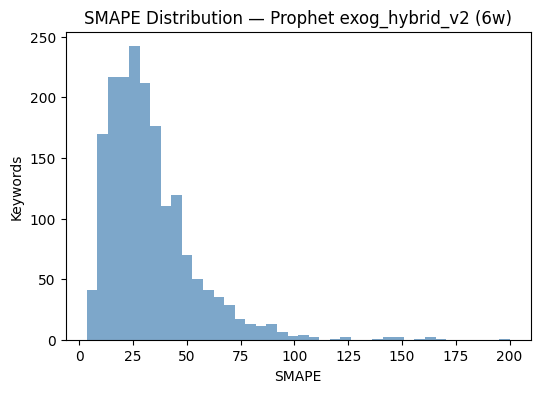

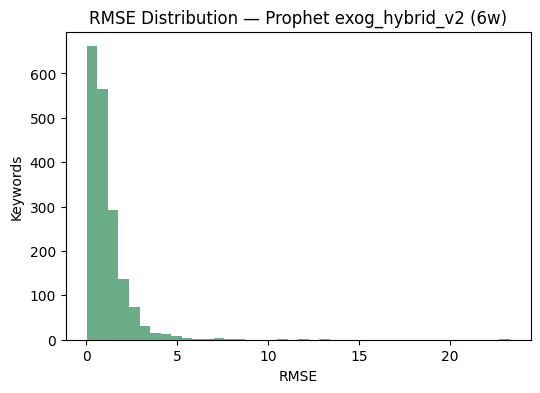


=== Comparison: exog_hybrid_v2 vs Baseline (exog_full, 6w) ===


,baseline_SMAPE_mean,baseline_SMAPE_median,baseline_RMSE_mean,baseline_RMSE_median,hybrid_v2_SMAPE_mean,hybrid_v2_SMAPE_median,hybrid_v2_RMSE_mean,hybrid_v2_RMSE_median
0,35.127,29.463,1.189,0.853,32.844,28.39,1.119,0.819


ΔSMAPE mean: -2.283 | median: -0.875
ΔRMSE  mean: -0.070 | median: -0.021


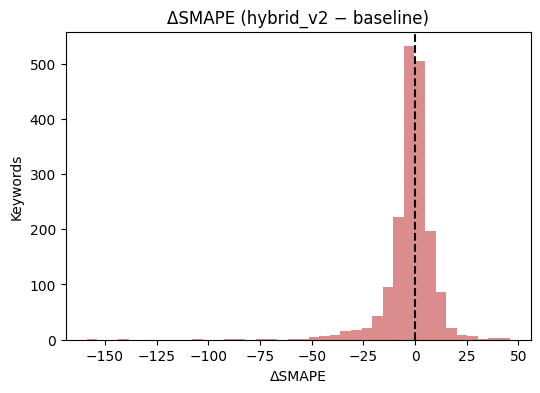

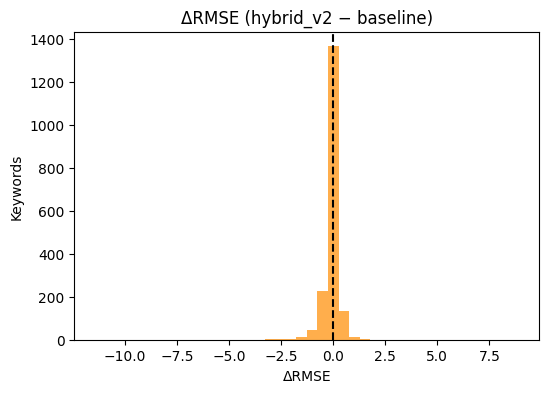

In [25]:
# === EVALUATION: Prophet exog_hybrid_v2 (6w) ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

BASE = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
HYB_V2_PATH = BASE / "prophet_semantic_exoghybrid" / "all_metrics.csv"
FULL_PATH   = BASE / "prophet_semantic_exogdiff"   / "all_metrics.csv"  # baseline comparison

assert HYB_V2_PATH.exists(), f"Missing: {HYB_V2_PATH}"
hyb_v2 = pd.read_csv(HYB_V2_PATH)
hyb_v2 = hyb_v2[(hyb_v2["cfg"].isin(["exog_hybrid", "exog_hybrid_v2"])) & (hyb_v2["horizon_weeks"]==6)].copy()

# === Summary ===
summary = {
    "keywords": int(hyb_v2["keyword"].nunique()),
    "SMAPE_mean": hyb_v2["smape"].mean(),
    "SMAPE_median": hyb_v2["smape"].median(),
    "SMAPE_p25": hyb_v2["smape"].quantile(0.25),
    "SMAPE_p75": hyb_v2["smape"].quantile(0.75),
    "RMSE_mean": hyb_v2["rmse"].mean(),
    "RMSE_median": hyb_v2["rmse"].median(),
    "RMSE_p25": hyb_v2["rmse"].quantile(0.25),
    "RMSE_p75": hyb_v2["rmse"].quantile(0.75),
    "avg_n_regressors": hyb_v2["n_regressors"].mean(),
}
print("=== Prophet exog_hybrid_v2 — 6-week Horizon Summary ===")
display(pd.DataFrame([summary]).round(3))

# === Top / Bottom 20 ===
leaderboard = hyb_v2[["keyword","smape","rmse","n_regressors"]].sort_values(["smape","rmse"])
print("\n=== 🔝 Top 20 keywords (lowest SMAPE) ===")
display(leaderboard.head(20))

print("\n=== 🔻 Worst 20 keywords (highest SMAPE) ===")
display(leaderboard.tail(20))

# === Histograms ===
plt.figure(figsize=(6,4))
plt.hist(hyb_v2["smape"].dropna(), bins=40, color="steelblue", alpha=0.7)
plt.title("SMAPE Distribution — Prophet exog_hybrid_v2 (6w)")
plt.xlabel("SMAPE"); plt.ylabel("Keywords")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(hyb_v2["rmse"].dropna(), bins=40, color="seagreen", alpha=0.7)
plt.title("RMSE Distribution — Prophet exog_hybrid_v2 (6w)")
plt.xlabel("RMSE"); plt.ylabel("Keywords")
plt.show()

# === Optional comparison with exog_full baseline ===
if FULL_PATH.exists():
    full = pd.read_csv(FULL_PATH)
    full = full[(full["cfg"]=="exog_full") & (full["horizon_weeks"]==6)].copy()

    comp = {
        "baseline_SMAPE_mean": full["smape"].mean(),
        "baseline_SMAPE_median": full["smape"].median(),
        "baseline_RMSE_mean": full["rmse"].mean(),
        "baseline_RMSE_median": full["rmse"].median(),
        "hybrid_v2_SMAPE_mean": summary["SMAPE_mean"],
        "hybrid_v2_SMAPE_median": summary["SMAPE_median"],
        "hybrid_v2_RMSE_mean": summary["RMSE_mean"],
        "hybrid_v2_RMSE_median": summary["RMSE_median"],
    }
    print("\n=== Comparison: exog_hybrid_v2 vs Baseline (exog_full, 6w) ===")
    display(pd.DataFrame([comp]).round(3))

    merged = hyb_v2.merge(full[["keyword","smape","rmse"]], on="keyword", how="inner", suffixes=("_hyb","_full"))
    merged["delta_smape"] = merged["smape_hyb"] - merged["smape_full"]
    merged["delta_rmse"]  = merged["rmse_hyb"]  - merged["rmse_full"]

    print(f"ΔSMAPE mean: {merged['delta_smape'].mean():.3f} | median: {merged['delta_smape'].median():.3f}")
    print(f"ΔRMSE  mean: {merged['delta_rmse'].mean():.3f} | median: {merged['delta_rmse'].median():.3f}")

    plt.figure(figsize=(6,4))
    plt.hist(merged["delta_smape"], bins=40, color="indianred", alpha=0.7)
    plt.title("ΔSMAPE (hybrid_v2 − baseline)"); plt.xlabel("ΔSMAPE"); plt.ylabel("Keywords")
    plt.axvline(0, color="black", linestyle="--")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(merged["delta_rmse"], bins=40, color="darkorange", alpha=0.7)
    plt.title("ΔRMSE (hybrid_v2 − baseline)"); plt.xlabel("ΔRMSE"); plt.ylabel("Keywords")
    plt.axvline(0, color="black", linestyle="--")
    plt.show()
else:
    print("\n(baseline exog_full metrics not found; skipping comparison.)")


Prophet ablation (v2 vs A/B/C) x 6w:   0%|          | 0/1811 [00:00<?, ?it/s]


✅ Ablation complete.
- all metrics: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid_ablation/all_metrics.csv

=== 6w Horizon — Variant Summary (lower is better) ===


,variant,keywords,SMAPE_mean,SMAPE_median,RMSE_mean,RMSE_median,avg_n_regressors
3,v2,1811,33.083,28.830,1.130,0.839,11.674
1,B,1811,33.202,29.039,1.133,0.832,12.674
2,C,1811,33.219,28.990,1.133,0.841,12.674
0,A,1811,33.476,28.939,1.155,0.841,12.674



=== Δ vs v2 (variant − v2) — mean / median ===


,variant,ΔSMAPE_mean_vs_v2,ΔSMAPE_median_vs_v2,ΔRMSE_mean_vs_v2,ΔRMSE_median_vs_v2,coverage_keywords
0,A,0.393,0.060,0.024,0.002,1811
1,B,0.119,-0.022,0.002,-0.000,1811
2,C,0.136,0.024,0.003,0.001,1811


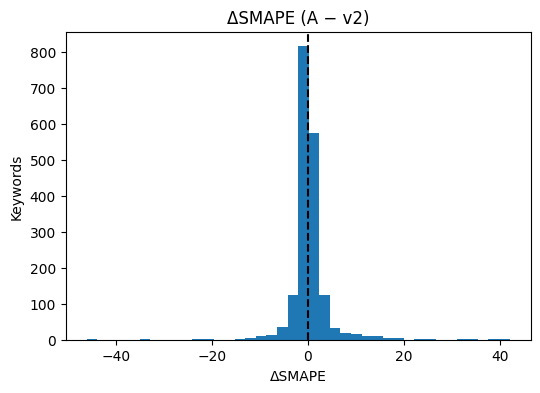

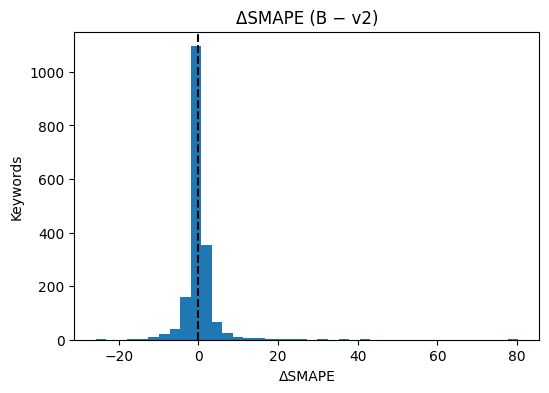

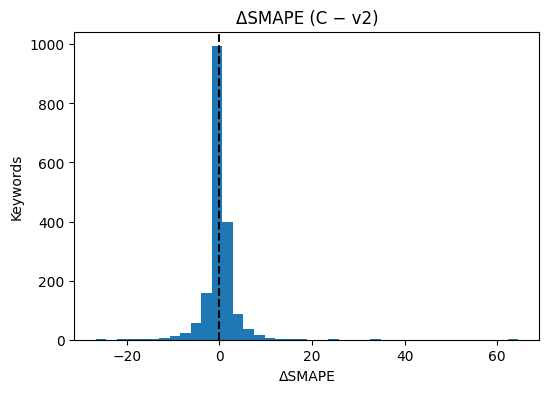

In [29]:
# === ABLATION (FULL RETRAIN PER KEYWORD): Prophet exog_hybrid_v2 vs A/B/C (6-week horizon) ===
# Variants:
#   v2: base hybrid (≈11 regressors)
#   A : v2 + impressions_sum_lag1
#   B : v2 + neighbor_mean_ema2 (EMA span=2, then lagged by 1)
#   C : v2 + neighbor_std
# Output dir: /content/drive/MyDrive/colab_data/cleaned_cpu/prophet_semantic_exoghybrid_ablation

!pip -q install polars pyarrow tqdm prophet cmdstanpy numpy pandas scikit-learn

from pathlib import Path
from datetime import date
import re, numpy as np, pandas as pd, polars as pl
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import matplotlib.pyplot as plt

# ---------------- Paths ----------------
BASE   = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
IN_DIR = BASE / "keywords_dfs_full_5"
OUT    = BASE / "prophet_semantic_exoghybrid_ablation"
OUT.mkdir(parents=True, exist_ok=True)

H = 6
NEIGH_PREFIX = "cpc_lastweek_"
VARIANTS = ["v2","A","B","C"]  # baseline + three single-add tests

# Per-variant forecast folders
FC_DIR = {v:(OUT / v / f"h{H}" / "forecasts") for v in VARIANTS}
for d in FC_DIR.values(): d.mkdir(parents=True, exist_ok=True)

# ---------------- Core Prophet config (the one that won for you) ----------------
def make_prophet(add_regressors=None):
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,     # already weekly-aggregated
        yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.09,
        changepoint_range=0.9,
        n_changepoints=30,
        seasonality_prior_scale=12,
        interval_width=0.8,
        stan_backend="CMDSTANPY",
    )
    m.add_seasonality("quarterly", period=91, fourier_order=5, prior_scale=10)
    if add_regressors:
        for r in add_regressors:
            m.add_regressor(r, standardize=True, prior_scale=0.25, mode="additive")
    return m

# ---------------- Helpers ----------------
def iso_week_to_date(wwyyyy: str):
    w, y = wwyyyy.split("-")
    return date.fromisocalendar(int(y), int(w), 1)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    denom = (np.abs(y_true)+np.abs(y_pred))/2.0
    m = denom != 0
    return float(100*np.mean(np.abs(y_pred[m]-y_true[m]) / denom[m]))

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))

def detect_neighbor_cols(cols, prefix=NEIGH_PREFIX):
    cols = [c for c in cols if isinstance(c, str)]
    cands = [c for c in cols if c.startswith(prefix)]
    def sort_key(x):
        m = re.search(r"(\d+)", x)
        return (0 if m else 1, int(m.group(1)) if m else 0, x)
    return sorted(cands, key=sort_key)

# base hybrid-v2 kept features (present columns only will be used)
KEEP_MAIN = [
    "impressions_sum",
    "n_dev_mobile",
    "n_st_branded_search",
    "avg_sim_top25_this_week",
    "n_sim_last_week",
    "avg_sim_top25_last_week_lag1",  # if present in parquet
]

def prep_base(pl_df: pl.DataFrame):
    # y and ds
    base = (
        pl_df.select(pl.col("week"), pl.col("cpc_week").cast(pl.Float64, strict=False).alias("y"))
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds").filter(pl.col("y").is_not_null())
    ).to_pandas()[["ds","y"]]

    # exogenous
    neigh_cols = detect_neighbor_cols(pl_df.columns, NEIGH_PREFIX)
    keep_present = [c for c in KEEP_MAIN if c in pl_df.columns]

    exdf = (
        pl_df.select(["week"] + keep_present + neigh_cols)
             .with_columns(pl.col("week").map_elements(iso_week_to_date, return_dtype=pl.Date).alias("ds"))
             .drop("week").sort("ds")
    ).to_pandas()

    for c in exdf.columns:
        if c != "ds":
            exdf[c] = pd.to_numeric(exdf[c], errors="coerce")

    # neighbor mean
    if neigh_cols:
        exdf["neighbor_mean"] = exdf[neigh_cols].mean(axis=1, skipna=True)
    else:
        exdf["neighbor_mean"] = np.nan

    # merge + basic fills
    full = base.merge(exdf, on="ds", how="left").replace([np.inf,-np.inf], np.nan).ffill().bfill()

    # lags for v2 base
    full["neighbor_mean_lag1"] = full["neighbor_mean"].shift(1)

    # build base reg list (approx 11 regs when all present)
    reg_cols = []
    for c in [
        "impressions_sum",
        "n_dev_mobile",
        "n_st_branded_search",
        "avg_sim_top25_this_week",
        "n_sim_last_week",
        "avg_sim_top25_last_week_lag1",
        "neighbor_mean_lag1",
    ]:
        if c in full.columns:
            reg_cols.append(c)

    # drop zero-variance regs
    if reg_cols:
        nun = full[reg_cols].nunique(dropna=False)
        reg_cols = [c for c in reg_cols if nun.get(c, 0) > 1]

    # finalize fills (lags may create NaN on first row)
    full = full.replace([np.inf,-np.inf], np.nan).ffill().bfill()
    return full, reg_cols, neigh_cols

def add_variant_features(full, neigh_cols, variant):
    """Return (df_with_features, updated_reg_cols) for given variant."""
    reg_cols = [c for c in full.columns if c not in ["ds","y"]]

    if variant == "v2":
        # nothing extra
        pass

    elif variant == "A":
        # demand inertia
        if "impressions_sum" in full.columns:
            full["impressions_sum_lag1"] = full["impressions_sum"].shift(1)
            reg_cols.append("impressions_sum_lag1")

    elif variant == "B":
        # smoother semantic persistence (EMA2 lag1)
        if "neighbor_mean" in full.columns:
            ema2 = full["neighbor_mean"].ewm(span=2, adjust=False).mean()
            full["neighbor_mean_ema2"] = ema2.shift(1)
            reg_cols.append("neighbor_mean_ema2")

    elif variant == "C":
        # volatility proxy
        if neigh_cols:
            # compute std on the fly using only available neighbor cols
            neigh_df = full[[c for c in neigh_cols if c in full.columns]].copy()
            # if we merged earlier, neighbor raw cols may not exist; recompute from exdf path if needed
            if neigh_df.shape[1] == 0:
                # nothing to add if no raw neighbor columns in 'full'
                pass
            else:
                full["neighbor_std"] = neigh_df.std(axis=1, skipna=True)
                reg_cols.append("neighbor_std")

    # clean, fill, and drop zero-variance again
    full = full.replace([np.inf,-np.inf], np.nan).ffill().bfill()
    if reg_cols:
        nun = full[reg_cols].nunique(dropna=False)
        reg_cols = [c for c in reg_cols if nun.get(c, 0) > 1]
    return full, reg_cols

def fit_eval_variant(full, reg_cols, kw, variant):
    if len(full) <= H + 5:
        return np.nan, np.nan, 0

    train = full.iloc[:-H].copy()
    test  = full.iloc[-H:].copy()

    # scale regressors
    if reg_cols:
        sc = StandardScaler()
        train[reg_cols] = sc.fit_transform(train[reg_cols].values)
        test[reg_cols]  = sc.transform(test[reg_cols].values)

    m = make_prophet(add_regressors=reg_cols)
    m.fit(train[["ds","y"] + reg_cols])

    fc = m.predict(test[["ds"] + reg_cols])

    # save per-keyword forecasts
    out_fc = FC_DIR[variant] / f"{kw}.csv"
    pd.DataFrame({
        "ds": test["ds"],
        "y_true": test["y"],
        "yhat": fc["yhat"],
        "yhat_lower": fc.get("yhat_lower", np.nan),
        "yhat_upper": fc.get("yhat_upper", np.nan),
    }).to_csv(out_fc, index=False)

    return smape(test["y"], fc["yhat"]), rmse(test["y"], fc["yhat"]), len(reg_cols)

# ---------------- Main loop: full retrain per keyword, for all variants ----------------
files = sorted(IN_DIR.glob("*.parquet"))
assert files, f"No parquet files found in {IN_DIR}"

records = []
for p in tqdm(files, desc="Prophet ablation (v2 vs A/B/C) x 6w"):
    kw = p.stem
    df_pl = pl.read_parquet(p)
    if "week" not in df_pl.columns or "cpc_week" not in df_pl.columns:
        continue

    # prepare base features once per keyword
    full, base_regs, neigh_cols = prep_base(df_pl)

    # train/eval each variant (including v2 baseline)
    for v in VARIANTS:
        df_v, regs_v = add_variant_features(full.copy(), neigh_cols, v)
        s, r, k = fit_eval_variant(df_v, regs_v, kw, v)
        records.append({
            "keyword": kw,
            "horizon_weeks": H,
            "cfg": f"exog_hybrid_{v}",
            "variant": v,
            "smape": s,
            "rmse": r,
            "n_regressors": k,
        })

# ---------------- Save & summarize ----------------
all_metrics = pd.DataFrame(records)
all_metrics_path = OUT / "all_metrics.csv"
all_metrics.to_csv(all_metrics_path, index=False)

print("\n✅ Ablation complete.")
print(f"- all metrics: {all_metrics_path}")

# Summary by variant
summary = (all_metrics.groupby("variant")
           .agg(keywords=("keyword","nunique"),
                SMAPE_mean=("smape","mean"),
                SMAPE_median=("smape","median"),
                RMSE_mean=("rmse","mean"),
                RMSE_median=("rmse","median"),
                avg_n_regressors=("n_regressors","mean"))
           .reset_index()
           .sort_values("SMAPE_mean"))
print("\n=== 6w Horizon — Variant Summary (lower is better) ===")
display(summary.round(3))

# Deltas vs v2
base = all_metrics[all_metrics["variant"]=="v2"][["keyword","smape","rmse"]].rename(
    columns={"smape":"smape_v2","rmse":"rmse_v2"}
)
rows = []
for v in ["A","B","C"]:
    mv = all_metrics[all_metrics["variant"]==v][["keyword","smape","rmse"]].rename(
        columns={"smape":f"smape_{v}","rmse":f"rmse_{v}"}
    )
    merged = base.merge(mv, on="keyword", how="inner")
    dsm = merged[f"smape_{v}"] - merged["smape_v2"]
    drm = merged[f"rmse_{v}"]  - merged["rmse_v2"]
    rows.append({"variant": v,
                 "ΔSMAPE_mean_vs_v2": dsm.mean(),
                 "ΔSMAPE_median_vs_v2": dsm.median(),
                 "ΔRMSE_mean_vs_v2": drm.mean(),
                 "ΔRMSE_median_vs_v2": drm.median(),
                 "coverage_keywords": len(merged)})
delta_tbl = pd.DataFrame(rows)
print("\n=== Δ vs v2 (variant − v2) — mean / median ===")
display(delta_tbl.round(3))

# Quick visuals
for v in ["A","B","C"]:
    mv = all_metrics[all_metrics["variant"]==v][["keyword","smape","rmse"]].rename(
        columns={"smape":"smape_v","rmse":"rmse_v"}
    )
    merged = base.merge(mv, on="keyword")
    plt.figure(figsize=(6,4))
    plt.hist(merged["smape_v"]-merged["smape_v2"], bins=40)
    plt.title(f"ΔSMAPE ({v} − v2)"); plt.axvline(0, color="k", ls="--"); plt.xlabel("ΔSMAPE"); plt.ylabel("Keywords")
    plt.show()


=== Summary @ 6-week horizon (mean, median, std, p25/p50/p75/p90) ===


,cfg,keywords,SMAPE_mean,SMAPE_median,SMAPE_std,SMAPE_p25,SMAPE_p50,SMAPE_p75,SMAPE_p90,RMSE_mean,RMSE_median,RMSE_std,RMSE_p25,RMSE_p50,RMSE_p75,RMSE_p90,avg_n_regressors
0,univariate,1811,38.282873,33.784101,23.269285,21.285531,33.784101,50.084998,69.924864,1.297608,0.990074,1.165328,0.538965,0.990074,1.667371,2.695757,0.000000
1,exog_small,1811,33.457428,28.465229,21.589642,18.920501,28.465229,41.614957,59.065608,1.132049,0.824678,1.182239,0.476875,0.824678,1.410106,2.198109,10.660409
2,exog_full,1811,33.442388,28.582864,21.412191,18.991079,28.582864,41.583666,59.228820,1.135176,0.831416,1.169200,0.485294,0.831416,1.397202,2.221967,14.660409
3,exog_hybrid,1811,32.842150,28.496272,20.611887,18.676648,28.496272,41.373172,58.255068,1.116635,0.821660,1.169701,0.471247,0.821660,1.368581,2.228881,11.000000



=== Hybrid minus baseline (paired per keyword) — lower is better ===


,cfg_vs,keywords_overlap,ΔSMAPE_mean,ΔSMAPE_median,ΔRMSE_mean,ΔRMSE_median,SMAPE_improved_%,RMSE_improved_%,ΔSMAPE_p25,ΔSMAPE_p50,ΔSMAPE_p75,ΔRMSE_p25,ΔRMSE_p50,ΔRMSE_p75
0,univariate,1811,-5.440723,-3.396763,-0.180973,-0.078291,65.599117,64.053009,-12.547199,-3.396763,2.281623,-0.352582,-0.078291,0.061975
1,exog_small,1811,-0.615278,-0.208475,-0.015414,-0.001345,51.297626,50.579790,-4.312929,-0.208475,4.211590,-0.120320,-0.001345,0.109220
2,exog_full,1811,-0.600237,-0.096102,-0.018541,-0.003429,50.911099,51.021535,-4.447187,-0.096102,3.965964,-0.119032,-0.003429,0.097451


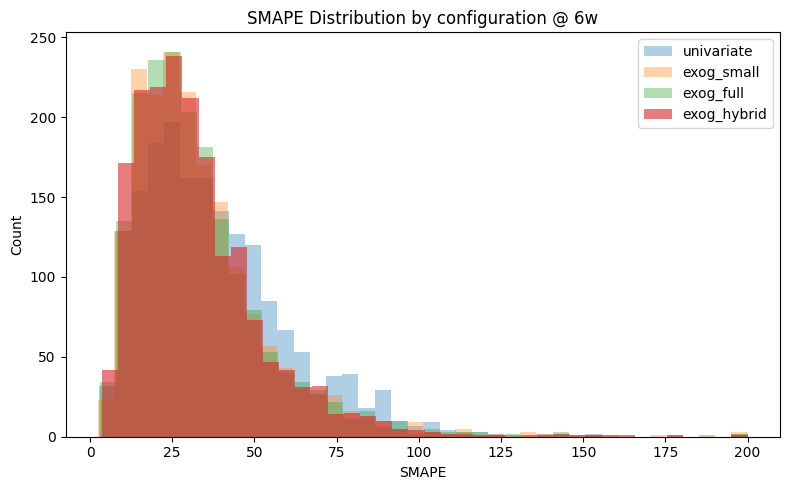

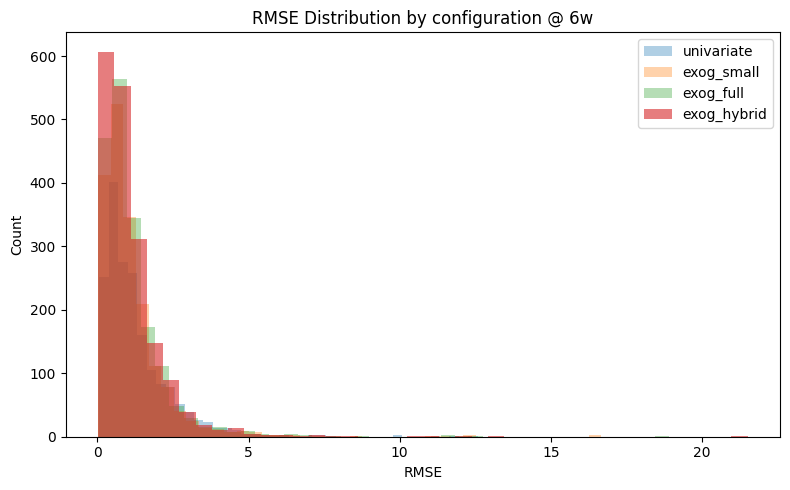


=== Focus: Median & 75th percentile (lower = better) ===


,cfg,SMAPE_median,SMAPE_p75,RMSE_median,RMSE_p75,avg_n_regressors
1,exog_small,28.465229,41.614957,0.824678,1.410106,10.660409
3,exog_hybrid,28.496272,41.373172,0.821660,1.368581,11.000000
2,exog_full,28.582864,41.583666,0.831416,1.397202,14.660409
0,univariate,33.784101,50.084998,0.990074,1.667371,0.000000


In [5]:
# === EVALUATION: Compare Prophet baselines (univariate / exog_small / exog_full) vs exog_hybrid @ 6w ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

BASE = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")

# inputs
BASELINE_PATH = BASE / "prophet_semantic_exogdiff"     / "all_metrics.csv"  # has univariate/exog_small/exog_full
HYBRID_PATH   = BASE / "prophet_semantic_exoghybrid"   / "all_metrics.csv"  # has exog_hybrid

assert BASELINE_PATH.exists(), f"Missing: {BASELINE_PATH}"
assert HYBRID_PATH.exists(),   f"Missing: {HYBRID_PATH}"

h = 6
cfgs_baseline = ["univariate","exog_small","exog_full"]
cfg_hybrid = "exog_hybrid"

# --- load ---
dfb = pd.read_csv(BASELINE_PATH)
dfh = pd.read_csv(HYBRID_PATH)

dfb = dfb[dfb["horizon_weeks"] == h].copy()
dfh = dfh[(dfh["horizon_weeks"] == h) & (dfh["cfg"] == cfg_hybrid)].copy()

# --- helper: summary table with quantiles + std ---
def summarize(df, label):
    s = {
        "cfg": label,
        "keywords": int(df["keyword"].nunique()),
        # SMAPE
        "SMAPE_mean":   float(df["smape"].mean()),
        "SMAPE_median": float(df["smape"].median()),
        "SMAPE_std":    float(df["smape"].std(ddof=1)),
        "SMAPE_p25":    float(df["smape"].quantile(0.25)),
        "SMAPE_p50":    float(df["smape"].quantile(0.50)),
        "SMAPE_p75":    float(df["smape"].quantile(0.75)),
        "SMAPE_p90":    float(df["smape"].quantile(0.90)),
        # RMSE
        "RMSE_mean":    float(df["rmse"].mean()),
        "RMSE_median":  float(df["rmse"].median()),
        "RMSE_std":     float(df["rmse"].std(ddof=1)),
        "RMSE_p25":     float(df["rmse"].quantile(0.25)),
        "RMSE_p50":     float(df["rmse"].quantile(0.50)),
        "RMSE_p75":     float(df["rmse"].quantile(0.75)),
        "RMSE_p90":     float(df["rmse"].quantile(0.90)),
        "avg_n_regressors": float(df["n_regressors"].mean()) if "n_regressors" in df else np.nan,
    }
    return pd.DataFrame([s])

# --- build summary for each cfg + hybrid ---
rows = []
for cfg in cfgs_baseline:
    rows.append(summarize(dfb[dfb["cfg"] == cfg], cfg))
rows.append(summarize(dfh, cfg_hybrid))
summary_all = pd.concat(rows, ignore_index=True)

print("=== Summary @ 6-week horizon (mean, median, std, p25/p50/p75/p90) ===")
display(summary_all)

# --- paired deltas: hybrid minus each baseline (only common keywords) ---
def paired_delta(baseline_cfg):
    b = dfb[dfb["cfg"] == baseline_cfg][["keyword","smape","rmse"]].rename(
        columns={"smape":"smape_base","rmse":"rmse_base"}
    )
    h = dfh[["keyword","smape","rmse"]].rename(
        columns={"smape":"smape_hyb","rmse":"rmse_hyb"}
    )
    m = h.merge(b, on="keyword", how="inner")
    if m.empty:
        return None
    m["delta_smape"] = m["smape_hyb"] - m["smape_base"]
    m["delta_rmse"]  = m["rmse_hyb"]  - m["rmse_base"]
    out = {
        "cfg_vs": baseline_cfg,
        "keywords_overlap": len(m),
        # central tendency of deltas
        "ΔSMAPE_mean": float(m["delta_smape"].mean()),
        "ΔSMAPE_median": float(m["delta_smape"].median()),
        "ΔRMSE_mean": float(m["delta_rmse"].mean()),
        "ΔRMSE_median": float(m["delta_rmse"].median()),
        # win rates
        "SMAPE_improved_%": float((m["delta_smape"] < 0).mean()*100.0),
        "RMSE_improved_%":  float((m["delta_rmse"]  < 0).mean()*100.0),
        # tail checks (optional)
        "ΔSMAPE_p25": float(m["delta_smape"].quantile(0.25)),
        "ΔSMAPE_p50": float(m["delta_smape"].quantile(0.50)),
        "ΔSMAPE_p75": float(m["delta_smape"].quantile(0.75)),
        "ΔRMSE_p25":  float(m["delta_rmse"].quantile(0.25)),
        "ΔRMSE_p50":  float(m["delta_rmse"].quantile(0.50)),
        "ΔRMSE_p75":  float(m["delta_rmse"].quantile(0.75)),
    }
    return pd.DataFrame([out]), m

delta_tables = []
paired_frames = {}
for cfg in cfgs_baseline:
    res = paired_delta(cfg)
    if res is None:
        continue
    tbl, frame = res
    delta_tables.append(tbl)
    paired_frames[cfg] = frame

if delta_tables:
    delta_summary = pd.concat(delta_tables, ignore_index=True)
    print("\n=== Hybrid minus baseline (paired per keyword) — lower is better ===")
    display(delta_summary)

# --- quick visuals (optional): SMAPE distributions by cfg ---
plt.figure(figsize=(8,5))
for cfg in cfgs_baseline:
    plt.hist(dfb[dfb["cfg"]==cfg]["smape"].dropna(), bins=40, alpha=0.35, label=cfg)
plt.hist(dfh["smape"].dropna(), bins=40, alpha=0.60, label="exog_hybrid")
plt.title("SMAPE Distribution by configuration @ 6w")
plt.xlabel("SMAPE"); plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# --- and RMSE too ---
plt.figure(figsize=(8,5))
for cfg in cfgs_baseline:
    plt.hist(dfb[dfb["cfg"]==cfg]["rmse"].dropna(), bins=40, alpha=0.35, label=cfg)
plt.hist(dfh["rmse"].dropna(), bins=40, alpha=0.60, label="exog_hybrid")
plt.title("RMSE Distribution by configuration @ 6w")
plt.xlabel("RMSE"); plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# --- (Optional) Focus on your objective: medians & p75 ---
focus_cols = [
    "cfg","SMAPE_median","SMAPE_p75","RMSE_median","RMSE_p75","avg_n_regressors"
]
print("\n=== Focus: Median & 75th percentile (lower = better) ===")
display(summary_all[focus_cols].sort_values("SMAPE_median"))
